### Install necessary libraries into the environment

In [5]:
# pip install -r requirements.txt

In [6]:
import tempfile
import shutil
import time

import pandas as pd
import numpy as np
import os
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import dill
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import random

# ANN BiLSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Embedding, Dropout
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2

# Cross validation
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, classification_report, accuracy_score

# Hyperparameter tuning
import keras_tuner as kt


from keras.callbacks import EarlyStopping
# from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib
from keras.callbacks import TensorBoard
from keras.models import load_model

In [7]:
# Run the python file join_excel_files.py and run the function join_files(source_directory, target_directory)
%run join_excel_files.py
# Create temp directory to store joined files
target_directory = tempfile.mkdtemp(prefix="OBE_")
user_input = input('Enter course codes separated by commas (Enter "all" to select all courses): ')
course_codes = [code.strip() for code in user_input.split(",")]
if 'all' in course_codes:
    course_codes = ['COM102', 'COM106', 'COM103', 'COM107', 'COM204', 'COM205', 'EEE202', 'EEE203', 'COM203', 'COM207', 'EEE301', 'EEE313', 'EEE401', 'EEE302', 'EEE303', 'EEE304', 'EEE316', 'EEE319', 'EEE305', 'EEE308', 'EEE309', 'EEE322', 'EEE310', 'EEE404', 'EEE406', 'EEE407', 'EEE411', 'EEE414', 'EEE405']
join_files('OBE Forms (New)', target_directory, course_codes)
directory_path = target_directory

print(f"Temp dir path: {directory_path}")

# Define function to delete temp directory
def delete_temp_directory(directory_path, retries=3, delay=1):
    if not os.path.exists(directory_path):
        print(f'Temporary directory "{directory_path}" does not exist.')
        return

    for i in range(retries):
        try:
            shutil.rmtree(directory_path)
            print(f"Temporary directory {directory_path} has been deleted.")
            return
        except PermissionError as e:
            print(f"Attempt {i + 1} failed: {e}")
            time.sleep(delay)
    print(f"Failed to delete temporary directory {directory_path} after {retries} attempts.")

All files have been copied.
Files have been filtered.
Temp dir path: C:\Users\mikek\AppData\Local\Temp\OBE_42ro9jnk


In [8]:
def process_obe_forms(directory_path):
    file_list = os.listdir(directory_path)
    unsupported_files = []
    results = {}

    # Loop over each file in file_list
    for file_name in file_list:
        try:
            print(file_name)
            # Results dictionary to store information about the files
            results[file_name] = {}
            xls = pd.ExcelFile(os.path.join(directory_path, file_name))
            
            # --- Start of processing code ---
            
            # Sheet title
            df_info = pd.read_excel(xls, "Setup", nrows=20)
            sheet_title = df_info.at[4, 'Unnamed: 0']
            if sheet_title == 'OBE Measurement Tools v3.1':
                sheet_title = 'OBE Measurement Tools v3.1 - Setup Sheet'
            results[file_name]['sheet_title'] = sheet_title
            
            # Course info
            df_info = pd.read_excel(xls, "Setup", skiprows=range(7), nrows=11)
            course_info = {}
            for index, row in df_info.iterrows():
                indicator = None
                value = None
                for cell in row:
                    if pd.notna(cell):
                        if indicator is None:
                            indicator = str(cell)
                        elif value is None:
                            value = str(cell)
                            course_info[indicator] = value
                            break
            results[file_name]['course_info'] = course_info
            
            # Components
            df_weights = pd.read_excel(xls, "Setup", header=0, usecols="H, J, M", skiprows=5, nrows=14)
            df_weights = df_weights.dropna(how='all')
            assessment_info = {}
            current_assessment = None
            for index, row in df_weights.iterrows():
                if pd.notna(row['Unnamed: 7']):
                    current_assessment = row['Unnamed: 7']
                    assessment_info[current_assessment] = []
                if current_assessment and pd.notna(row['Component']):
                    if isinstance(assessment_info[current_assessment], list):
                        assessment_info[current_assessment].append((row['Component'], row['%'] / 100))
                elif current_assessment and pd.isna(row['Component']) and pd.notna(row['%']):
                    if isinstance(assessment_info[current_assessment], list):
                        assessment_info[current_assessment] = row['%'] / 100
            results[file_name]['assessment_info'] = assessment_info
            
            # Extract CLO/PLO Mappings table
            clos_amount = 5
            if 'CLO9' in str(pd.read_excel(xls, sheet_name="Setup").iloc[31, 0]):
                clos_amount = 9
            elif 'CLO1' in str(pd.read_excel(xls, sheet_name="Setup").iloc[35, 0]):
                clos_amount = 8
            elif 'CLO1' in str(pd.read_excel(xls, sheet_name="Setup").iloc[32, 0]):
                clos_amount = 5
            if clos_amount == 9:
                df_clo_plo_mappings = pd.read_excel(xls, "Setup", skiprows = 23, header = [0], nrows = 9)
            elif clos_amount == 8:
                df_clo_plo_mappings = pd.read_excel(xls, "Setup", skiprows = 23, header = [0], nrows = 8)
            elif clos_amount == 5:
                df_clo_plo_mappings = pd.read_excel(xls, "Setup", skiprows = 23, header = [0], nrows = 5)
            df_clo_plo_mappings = df_clo_plo_mappings.dropna(how = 'all')
            results[file_name]['df_clo_plo_mappings'] = df_clo_plo_mappings
            
            # CLO/PLO Mappings
            clo_plo_mappings = []
            for col in df_clo_plo_mappings.columns[2:]:
                for index, row in df_clo_plo_mappings.iterrows():
                    if row[col] == 'Y':
                        clo = row['Unnamed: 0']
                        plo = col
                        clo_plo_mappings.append((clo, plo))
            results[file_name]['clo_plo_mappings'] = clo_plo_mappings
            
            # CLO/Assessment Mapping for CA
            if clos_amount == 9:
                df_clo_ass_ca = pd.read_excel(xls, "Setup", skiprows=35, header=[0, 1], nrows=11)
            elif clos_amount == 8:
                df_clo_ass_ca = pd.read_excel(xls, "Setup", skiprows=34, header=[0, 1], nrows=10)
            elif clos_amount == 5:
                df_clo_ass_ca = pd.read_excel(xls, "Setup", skiprows = 31, header = [0, 1], nrows = 7)
            df_clo_ass_ca = df_clo_ass_ca.dropna(how = 'all')
            results[file_name]['df_clo_ass_ca'] = df_clo_ass_ca
            
            # CLO mapping to Assessment CA
            clo_ass_ca = []
            if clos_amount == 9:
                section_marks_row = 9
            elif clos_amount == 8:
                section_marks_row = 8
            elif clos_amount == 5:
                section_marks_row =5
            for col in df_clo_ass_ca.columns[2:]:
                for index, row in df_clo_ass_ca.iterrows():
                    if row[col] == 'Y':
                        clo = row[('Course Learning Outcome (CLO)', 'Unnamed: 0_level_1')]
                        question = col[1]
                        assessment = col[0]
                        section_marks = df_clo_ass_ca.at[section_marks_row, col]
                        clo_ass_ca.append((clo, question, assessment, section_marks))
            results[file_name]['clo_ass_ca'] = clo_ass_ca

            total_marks_ca = {}
            for _, _, assessment, section_marks in clo_ass_ca:
                if assessment in total_marks_ca:
                    total_marks_ca[assessment] += section_marks
                else:
                    total_marks_ca[assessment] = section_marks
            results[file_name]['total_marks_ca'] = total_marks_ca
            
            # CLO/Assessment Mapping for FA
            if clos_amount == 9:
                df_clo_ass_fa = pd.read_excel(xls, "Setup", skiprows = 50, header = [0, 1], nrows = 11)
            elif clos_amount == 8:
                df_clo_ass_fa = pd.read_excel(xls, "Setup", skiprows=48, header = [0, 1], nrows=10)
            elif clos_amount == 5:
                df_clo_ass_fa = pd.read_excel(xls, "Setup", skiprows = 42, header = [0, 1], nrows = 7)
            df_clo_ass_fa = df_clo_ass_fa.dropna(how = 'all')
            results[file_name]['df_clo_ass_fa'] = df_clo_ass_fa
            
            # CLO mapping to Assessment FA
            clo_ass_fa = []
            for col in df_clo_ass_fa.columns[2:]:
                for index, row in df_clo_ass_fa.iterrows():
                    if row[col] == 'Y':
                        clo = row[('Course Learning Outcome (CLO)', 'Unnamed: 0_level_1')]
                        question = col[1]
                        assessment = col[0]
                        section_marks = df_clo_ass_fa.at[section_marks_row, col]
                        clo_ass_fa.append((clo, question, assessment, section_marks))
            results[file_name]['clo_ass_fa'] = clo_ass_fa

            total_marks_fa = {}
            total_marks_fa = {}
            for _, _, assessment, section_marks in clo_ass_fa:
                if assessment in total_marks_fa:
                    total_marks_fa[assessment] += section_marks
                else:
                    total_marks_fa[assessment] = section_marks
            results[file_name]['total_marks_fa'] = total_marks_fa
            
            # Unique CLO list
            unique_clos = set()
            for clo, _, _, _ in clo_ass_ca:
                unique_clos.add(clo)
            for clo, _, _, _ in clo_ass_fa:
                unique_clos.add(clo)
            unique_clos_list = sorted(unique_clos, key=lambda x: int(x[3:]))
            results[file_name]['unique_clos_list'] = unique_clos_list
            
            # CLO - Assessments
            clo_assessments = {clo: [] for clo in unique_clos_list}
            for clo, questions, assessment, score in clo_ass_ca:
                clo_assessments[clo].append((questions, assessment, score))
            for clo, questions, assessment, score in clo_ass_fa:
                clo_assessments[clo].append((questions, assessment, score))
            results[file_name]['clo_assessments'] = clo_assessments

            # CLO weightages and percentages
            total_marks = {**total_marks_ca, **total_marks_fa}
            clo_assessment_marks = defaultdict(float)
            for clo, _, assessment, marks in clo_ass_ca:
                clo_assessment_marks[(clo, assessment)] += marks
            for clo, _, assessment, marks in clo_ass_fa:
                clo_assessment_marks[(clo, assessment)] += marks
            assessment_weightage = {}
            for key, value in assessment_info.items():
                if isinstance(value, list):
                    for assessment, weight in value:
                        assessment_weightage[assessment] = weight
                else:
                    assessment_weightage[key] = value
            clo_weightages = defaultdict(float)
            for (clo, assessment), marks_allocated in clo_assessment_marks.items():
                total_marks_assessment = total_marks[assessment]
                weightage_assessment = assessment_weightage[assessment]
                weightage = (marks_allocated / total_marks_assessment) * weightage_assessment
                clo_weightages[(clo, assessment)] = weightage
            clo_total_weightages = defaultdict(float)
            for (clo, assessment), weightage in clo_weightages.items():
                clo_total_weightages[clo] += weightage
            clo_percentages = {}
            for (clo, assessment) in clo_weightages.keys():
                weightage = clo_weightages[(clo, assessment)]
                total_weightage = clo_total_weightages[clo]
                percentage = (weightage / total_weightage)
                clo_percentages[(clo, assessment)] = percentage
            results[file_name]['clo_percentages'] = clo_percentages
            results[file_name]['clo_weightages'] = clo_weightages
            
            # Extract student marks CA and FA
            df_student_marks_ca = pd.read_excel(xls, "Student Marks CA", skiprows = 21, header = [0, 1])
            df_student_marks_ca = df_student_marks_ca.drop(columns = [('Unnamed: 0_level_0', 'No.')])
            df_student_marks_ca = df_student_marks_ca.dropna(how = 'all')
            df_student_marks_ca = df_student_marks_ca.dropna(axis=1, how='all')
            
            df_student_marks_fa = pd.read_excel(xls, "Student Marks FA", skiprows = 21, header = [0, 1])
            df_student_marks_fa = df_student_marks_fa.drop(columns = [('Unnamed: 0_level_0', 'No.')])
            df_student_marks_fa = df_student_marks_fa.dropna(how = 'all')
            df_student_marks_fa = df_student_marks_fa.dropna(axis=1, how='all')
            
            # Merge CA and FA data
            final_assessment_columns = [col for col in df_student_marks_fa.columns if col[0] == 'Final Assessment']
            df_final_assessment = df_student_marks_fa[final_assessment_columns]
            df_student_marks_combined = pd.concat([df_student_marks_ca, df_final_assessment], axis=1)
            df_student_marks_combined = df_student_marks_combined.dropna(subset=[("Unnamed: 1_level_0", 'Student ID')])
            results[file_name]['df_student_marks_combined'] = df_student_marks_combined
            
            # Obtain CLO from CA and FA
            adjusted_clo_percentages = defaultdict(lambda: defaultdict(float))
            clo_assessment_total_marks = defaultdict(lambda: defaultdict(float))
            for clo, assessments in clo_assessments.items():
                for _, assessment, marks in assessments:
                    clo_assessment_total_marks[clo][assessment] += marks
            for clo, assessments in clo_assessments.items():
                for _, assessment, marks in assessments:
                    total_marks = clo_assessment_total_marks[clo][assessment]
                    adjusted_percentage = marks / total_marks
                    adjusted_clo_percentages[clo][assessment] += adjusted_percentage
            clo_scores = defaultdict(lambda: defaultdict(list))
            clo_max_scores = defaultdict(lambda: defaultdict(list))
            clo_assessment_percentages = defaultdict(lambda: defaultdict(list))
            clo_assessment_details = defaultdict(lambda: defaultdict(list))
            for clo, assessments in clo_assessments.items():
                for question, assessment, max_score in assessments:
                    col_pair = (assessment, question)
                    if col_pair not in df_student_marks_combined.columns:
                        continue
                    for _, row in df_student_marks_combined.iterrows():
                        student_id = row[('Unnamed: 1_level_0', 'Student ID')]
                        student_name = row[('Unnamed: 2_level_0', 'Student Name')]
                        student_score = row[col_pair]
                        clo_scores[(student_id, student_name)][clo].append(student_score)
                        clo_max_scores[(student_id, student_name)][clo].append(max_score)
                        clo_assessment_percentages[(student_id, student_name)][clo].append(clo_percentages.get((clo, assessment), 0))
                        clo_assessment_details[(student_id, student_name)][clo].append((assessment, question))
            student_clo_data = defaultdict(lambda: defaultdict(list))
            for (student_id, student_name), scores in clo_scores.items():
                for clo, score_list in sorted(scores.items()):
                    max_score_list = clo_max_scores[(student_id, student_name)][clo]
                    total_max_score = sum(max_score_list)
                    assessment_details_list = clo_assessment_details[(student_id, student_name)][clo]
                    for score, max_score, (assessment, question) in zip(score_list, max_score_list, assessment_details_list):
                        percentage = clo_percentages.get((clo, assessment), 0)
                        student_clo_data[(student_id, student_name)][clo].append({
                            'score': score,
                            'max_score': max_score,
                            'percentage': percentage,
                            'assessment': assessment,
                            'question': question
                        })
            results[file_name]['student_clo_data'] = student_clo_data



            # ~~~~~~~~~~~~
            # Student CLO values (from marks to values of CLO parts)
            max_scores_per_clo_assessment = {}
            total_max_scores = {}
            for (student_id, student_name), clo_data in student_clo_data.items():
                for clo, data_list in clo_data.items():
                    for data in data_list:
                        assessment = data['assessment']
                        question = data['question']
                        max_score = data['max_score']
                        key = (clo, assessment)
                        if key not in max_scores_per_clo_assessment:
                            max_scores_per_clo_assessment[key] = {}
                        if question not in max_scores_per_clo_assessment[key]:
                            max_scores_per_clo_assessment[key][question] = max_score
                break
            for (clo, assessment), question_max_scores in max_scores_per_clo_assessment.items():
                total_max_score = sum(question_max_scores.values())
                total_max_scores[(clo, assessment)] = total_max_score
            student_clo_values = defaultdict(dict)
            for (student_id, student_name), clo_data in student_clo_data.items():
                if pd.isna(student_id) or pd.isna(student_name):
                    continue
                for clo, data_list in clo_data.items():
                    clo_value = 0
                    for data in data_list:
                        score = data['score']
                        max_score = data['max_score']
                        assessment = data['assessment']
                        question = data['question']
                        key = (clo, assessment)
                        total_max_score = total_max_scores[key]
                        clo_assessment_percentage = clo_percentages.get((clo, assessment), 0)
                        adjusted_percentage = (max_score / total_max_score) * clo_assessment_percentage
                        value = (score / max_score) * adjusted_percentage
                        clo_value += value
                    student_clo_values[(student_id, student_name)][clo] = clo_value
            results[file_name]['student_clo_values'] = student_clo_values
            
            # Overall CLOs DataFrame
            students_info = df_student_marks_combined[[
                ('Unnamed: 1_level_0', 'Student ID'), 
                ('Unnamed: 2_level_0', 'Student Name')
            ]].drop_duplicates()
            students_info = students_info.dropna(subset=[('Unnamed: 1_level_0', 'Student ID'),
                                                         ('Unnamed: 2_level_0', 'Student Name')])   
            clo_columns = list(clo_assessments.keys())
            category_columns = [f"Category_{clo}" for clo in clo_columns]
            student_clo_df = pd.DataFrame(columns=['Student_ID', 'Student_Name'] + clo_columns + category_columns)
            rows = []
            def categorize_clo(value):
                if value >= 80:
                    return 'Strong'
                elif value >= 50:
                    return 'Moderate'
                else:
                    return 'Weak'
            for _, row in students_info.iterrows():
                student_id = row[('Unnamed: 1_level_0', 'Student ID')]
                student_name = row[('Unnamed: 2_level_0', 'Student Name')]
                clo_values = student_clo_values.get((student_id, student_name), {})
                if not clo_values or any(pd.isna(v) for v in clo_values.values()):
                    continue
                row_data = {'Student_ID': student_id, 'Student_Name': student_name}
                formatted_clo_values = {clo: f"{value * 100:.2f}%" for clo, value in clo_values.items()}
                categorized_clo_values = {f"Category_{clo}": categorize_clo(value * 100) for clo, value in clo_values.items()}
                row_data.update(formatted_clo_values)
                row_data.update(categorized_clo_values)
                rows.append(row_data)
            student_clo_df = pd.concat([student_clo_df, pd.DataFrame(rows)], ignore_index=True)
            student_clo_df.reset_index(drop=True, inplace=True)
            results[file_name]['student_clo_df'] = student_clo_df
            
            # Overall PLOs DataFrame
            def categorize_value(value):
                percentage = value * 100
                if 80 <= percentage <= 100:
                    return 'Strong'
                elif 50 <= percentage < 80:
                    return 'Moderate'
                else:
                    return 'Weak'
            plo_clo_mappings = defaultdict(set)
            for clo, plo in clo_plo_mappings:
                plo_clo_mappings[plo].add(clo)
            student_plo_values = defaultdict(dict)
            for (student_id, student_name), clo_values in student_clo_values.items():
                plo_values = {}
                for plo in plo_clo_mappings.keys():
                    mapped_clos = plo_clo_mappings[plo]
                    student_clo_vals = [clo_values[clo] for clo in mapped_clos if clo in clo_values]
                    if student_clo_vals:
                        avg_value = sum(student_clo_vals) / len(student_clo_vals)
                        plo_values[plo] = avg_value
                    else:
                        plo_values[plo] = 0.0
                student_plo_values[(student_id, student_name)] = plo_values
            all_plo_columns = [f'PLO{i}' for i in range(1, 13)]
            category_columns = [f"Category_{plo}" for plo in all_plo_columns]
            student_plo_df = pd.DataFrame(columns=['Student_ID', 'Student_Name'] + all_plo_columns + category_columns)
            rows = []
            for (student_id, student_name), plo_values in student_plo_values.items():
                row_data = {'Student_ID': student_id, 'Student_Name': student_name}
                for plo in all_plo_columns:
                    row_data[plo] = '0.00%'
                    row_data[f"Category_{plo}"] = 'N/A'
                for plo, value in plo_values.items():
                    formatted_value = f"{value * 100:.2f}%"
                    category = categorize_value(value)
                    row_data[plo] = formatted_value
                    row_data[f"Category_{plo}"] = category
                rows.append(row_data)
            student_plo_df = pd.concat([student_plo_df, pd.DataFrame(rows)], ignore_index=True)
            results[file_name]['student_plo_df'] = student_plo_df
            
            print(file_name, "done")

        except KeyError as e:
            if file_name in results:
                del results[file_name]
            unsupported_files.append(file_name)
            continue

    print("Unsupported files:", unsupported_files)

    return results

    # --- End of processing code ---

In [9]:
results = process_obe_forms(target_directory)
results_copy = results.copy()
    # 3 unsupported files: in "Setup" sheet row 49 --> "Final Report" for CLO/Assessment Mappings for Final Assessment, but in "Student Marks FA" sheet, it is "Final Assessment"

OBE 2020-04-All OBE 2020-04-2004_COM205_OBE Template v3.1-EE.XLSX
OBE 2020-04-All OBE 2020-04-2004_COM205_OBE Template v3.1-EE.XLSX done
OBE 2020-04-All OBE 2020-04-COM203 OBE Template v3.1-EE.xlsx
OBE 2020-04-All OBE 2020-04-COM203 OBE Template v3.1-EE.xlsx done
OBE 2020-04-All OBE 2020-04-EEE301_OBE Template v3.1-EE.XLSX
OBE 2020-04-All OBE 2020-04-EEE301_OBE Template v3.1-EE.XLSX done
OBE 2020-04-All OBE 2020-04-EEE304_HVE_OBE Template v3.1-EE.XLSX
OBE 2020-04-All OBE 2020-04-EEE304_HVE_OBE Template v3.1-EE.XLSX done
OBE 2020-04-All OBE 2020-04-EEE322 OBE.XLSX
OBE 2020-04-All OBE 2020-04-EEE322 OBE.XLSX done
OBE 2020-04-All OBE 2020-04-EEE401_OBE Template v3.1-EE.XLSX
OBE 2020-04-All OBE 2020-04-EEE401_OBE Template v3.1-EE.XLSX done
OBE 2020-04-All OBE 2020-04-OBE Template v3.1- EEE302 - Dr. Nisa.XLSX
OBE 2020-04-All OBE 2020-04-OBE Template v3.1- EEE302 - Dr. Nisa.XLSX done
OBE 2020-04-All OBE 2020-04-OBE Template v3.1- EEE316 - Dr. Nisa.XLSX
OBE 2020-04-All OBE 2020-04-OBE Templat

In [10]:
delete_temp_directory(directory_path, retries=3, delay=1)

Attempt 1 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_42ro9jnk\\OBE 2023-09-EEE322 202309 ORI.XLSX'
Attempt 2 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_42ro9jnk\\OBE 2023-09-EEE322 202309 ORI.XLSX'
Attempt 3 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_42ro9jnk\\OBE 2023-09-EEE322 202309 ORI.XLSX'
Failed to delete temporary directory C:\Users\mikek\AppData\Local\Temp\OBE_42ro9jnk after 3 attempts.


PLO1: 4761
PLO2: 7097
PLO3: 4210
PLO4: 2018
PLO5: 3497
PLO6: 809
PLO7: 953
PLO8: 745
PLO9: 827
PLO10: 1895
PLO11: 921
PLO12: 986


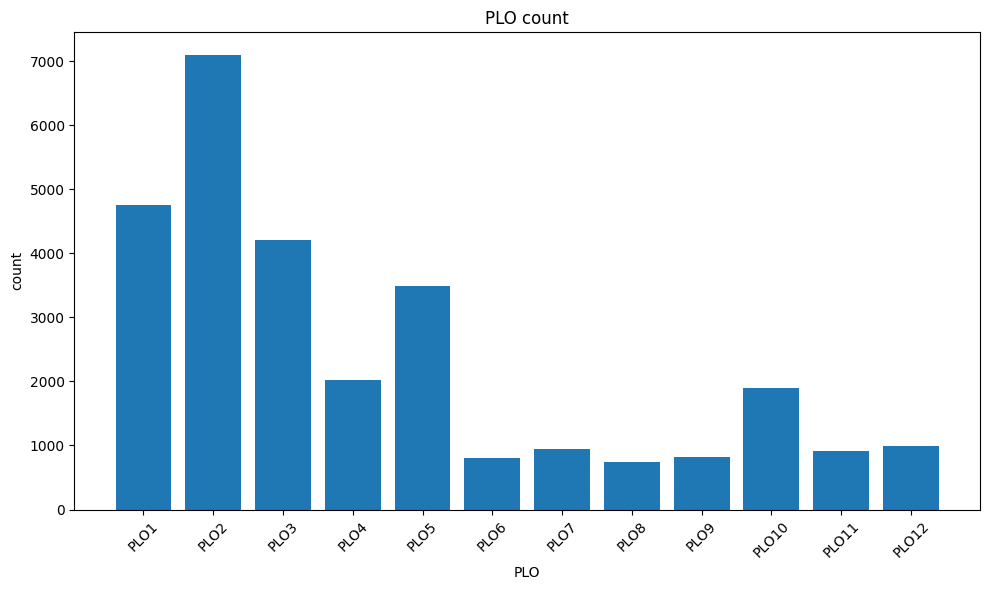

In [11]:
# Initialize a dictionary to store the counts for each PLO
plo_counts = {f'PLO{i}': 0 for i in range(1, 13)}

for file_name, data in results.items():
    student_plo_df = data.get('student_plo_df')
    if isinstance(student_plo_df, pd.DataFrame):
        # Iterate through each PLO column
        for plo in plo_counts.keys():
            if plo in student_plo_df.columns:
                # Count non-null and non-zero rows for the current PLO column
                non_null_non_zero_count = student_plo_df[plo].notnull().sum() - (student_plo_df[plo] == "0.00%").sum()
                plo_counts[plo] += non_null_non_zero_count

for plo, count in plo_counts.items():
    print(f"{plo}: {count}")

# Bar chart
plt.figure(figsize=(10, 6))
plt.bar(plo_counts.keys(), plo_counts.values())
plt.xlabel('PLO')
plt.ylabel('count')
plt.title('PLO count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
delete_temp_directory(directory_path, retries=3, delay=1)

Attempt 1 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_42ro9jnk\\OBE 2023-09-EEE322 202309 ORI.XLSX'
Attempt 2 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_42ro9jnk\\OBE 2023-09-EEE322 202309 ORI.XLSX'
Attempt 3 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_42ro9jnk\\OBE 2023-09-EEE322 202309 ORI.XLSX'
Failed to delete temporary directory C:\Users\mikek\AppData\Local\Temp\OBE_42ro9jnk after 3 attempts.


### Student ID and Name

In [13]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [14]:
# extract student ID and name from a DataFrame
def extract_student_id_and_name(df):
    if 'Student_ID' in df.columns and 'Student_Name' in df.columns:
        return df[['Student_ID', 'Student_Name']]
    else:
        raise ValueError("DataFrame does not have the required columns: 'Student_ID' and 'Student_Name'")

# get unique student and student ID
def display_all_unique_students(results):
    student_tracking = defaultdict(list)
    all_students = {}
    for file_name, data in results.items():
        try:
            student_plo_df = data['student_plo_df']
            if isinstance(student_plo_df, pd.DataFrame):
                extracted_data = extract_student_id_and_name(student_plo_df)
                extracted_data = extracted_data.dropna(subset=['Student_ID', 'Student_Name'], how='all')
                student_list = list(extracted_data.itertuples(index=False, name=None))
                student_tracking[file_name].extend(student_list)
                for student_id, student_name in student_list:
                    all_students[student_id] = student_name
            else:
                raise ValueError("student_plo_df is not a DataFrame")
        except ValueError as e:
            print(f"Error processing file {file_name}: {e}")
    return all_students, student_tracking

In [15]:
all_students, student_tracking = display_all_unique_students(results)

print("All unique students:")
for student_id, student_name in all_students.items():
    print(f"  Student ID: {student_id}, Student Name: {student_name}")

All unique students:
  Student ID: EEE1709131, Student Name: He Pinchao
  Student ID: EEE1809160, Student Name: Han Linlin
  Student ID: EEE1809161, Student Name: Hong Xiaolin
  Student ID: EEE1809176, Student Name: Sun TianShi
  Student ID: EEE1809178, Student Name: Wang Jiacheng
  Student ID: EEE1809186, Student Name: Zhan Kesheng
  Student ID: EEE1902029, Student Name: Koong Won Wei
  Student ID: EEE1902030, Student Name: Tan Yee Yang
  Student ID: EEE1902179, Student Name: Elsayad Galaleldien Mohamed Galal Aly Aly
  Student ID: EEE1904041, Student Name: Kenny Chin Guan Rong
  Student ID: EEE1904042, Student Name: Lim Meng Jun
  Student ID: EEE1904043, Student Name: Lye Yuen Ean
  Student ID: EEE1904200, Student Name: Cui Yang
  Student ID: EEE1904714, Student Name: Chin Jun Jie
  Student ID: EEE1904715, Student Name: Chew Yong Huang
  Student ID: EEE1904716, Student Name: Pek Wan Rong
  Student ID: EEE1904717, Student Name: Steven Yong Choong Hong
  Student ID: EEE1904719, Student 

In [16]:
# Standardization for unusual cases
def standardize_allstudents_dict(all_students):
    new_dict = {}
    for stud_id, name in all_students.items():
        # Handle this case:  'EEE2002037 ': 'Raymond Khor Er Chie ', where there's extra spaces
        new_name = name.strip()
        new_id = stud_id.strip()

        # Handle this case: 'Chen Yuheng': 'EEE1709075', where name and ID are swapped (Student ID is 3 letters followed by 7 digits)
        # Check if the name looks like an ID and if the ID looks like a name, then swap
        if len(new_name) == 10 and new_name[:3].isalpha() and new_name[3:].isdigit():
            new_dict[new_name] = new_id
        else:
            new_dict[new_id] = new_name

        # Handle the last case:  'Chen Junfei': 'Chen Junfei', where name and ID are the same --> delete the entry
        if new_name == new_id:
            new_dict.pop(new_id)

    # Replace the original dictionary with the new one
    all_students_new = new_dict
    return all_students_new

In [17]:
all_students_new = standardize_allstudents_dict(all_students)

In [18]:
# Group the intakes into a dictionary
# e.g., EEE1709 is intake 17/09 (see from the numbers)
# Group the x/02 and x/04 intakes together
# So for each year, there's 2 groups e.g., 19/02-04, 19/09

def group_intakes(all_students_new):
    intakes = {}
    for id, name in all_students_new.items():
        intake = id[3:7]
        if intake in intakes:
            intakes[intake].append(id)
        else:
            intakes[intake] = [id]

    # Sort the intakes
    intakes = dict(sorted(intakes.items()))
    return intakes

In [19]:
intakes = group_intakes(all_students_new)

In [20]:
def make_intakes_array(intakes):
    for intake in intakes:
        globals()[f'student_ids_{intake}'] = intakes[intake]
    intakes_array = [globals()[f'student_ids_{intake}'] for intake in sorted(intakes.keys())]
    return intakes_array

In [21]:
intakes_array = make_intakes_array(intakes)

In [22]:
# files with the specified student inside it
def student_files(student_ids_intake, results_arg):
    student_files_dict = {}
    for student_id in tqdm(student_ids_intake):
        student_files = []
        for file_name, data in results_arg.items():
            df = data['student_plo_df']
            if student_id in df['Student_ID'].values:
                student_files.append(file_name)

        student_files_dict[student_id] = student_files

    for student_id, files in student_files_dict.items():
        print(f"Student ID: {student_id}")
        for file in files:
            print(f"  File: {file}")

    return student_files_dict

In [23]:
# individual display
%run individual_display_new.py

def individual_display_all(student_files_dict, results_dict):
    individual_display_results = {}
    for student_id, file_list in tqdm(student_files_dict.items()):
        studentId, studentName, allStudentRows = individual_display_row(student_id, file_list, results_dict)
        individual_display_results[studentId] = (studentId, studentName, allStudentRows)
    return individual_display_results

In [24]:
# get files for all intake
def process_individual_display(intakes_arg, results_arg):
    for intake in intakes_arg:
        student_ids = globals()[f'student_ids_{intake}']
        student_files_intake = student_files(student_ids, results_arg)
        individual_display_intake = individual_display_all(student_files_intake, results_arg)
        
        # Combine individual displays
        individual_display_intake_combined = pd.concat([df[2] for df in individual_display_intake.values()], ignore_index=True)
        
        # Prepare DataFrame with Student_ID and Name
        dfs_ID_name_intake = []
        for key, value in individual_display_intake.items():
            df = value[2].copy()
            df['Student_ID'] = value[0]
            df['Name'] = value[1]
            dfs_ID_name_intake.append(df)
        
        individual_display_intake_combined = pd.concat(dfs_ID_name_intake, ignore_index=True)
        
        # Reorder columns to have Student_ID and Name first
        cols = individual_display_intake_combined.columns.tolist()
        cols = cols[-2:] + cols[:-2]
        individual_display_intake_combined = individual_display_intake_combined[cols]
        
        # Store the results in global variables
        globals()[f'student_files_{intake}'] = student_files_intake
        globals()[f'individual_display_{intake}'] = individual_display_intake
        globals()[f'dfs_ID_name_{intake}'] = dfs_ID_name_intake
        globals()[f'individual_display_{intake}_combined'] = individual_display_intake_combined

In [25]:
# process all intakes
process_individual_display(intakes, results)

100%|██████████| 2/2 [00:00<00:00, 142.84it/s]


Student ID: EGE1609009
  File: OBE 2020-04-All OBE 2020-04-EEE401_OBE Template v3.1-EE.XLSX
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1-EE-EEE309-sem 202004.xlsx
  File: OBE 2020-04-Intake 2017-09-EEE305-Co-2017-09.xlsx
  File: OBE 2020-04-Intake 2017-09-EEE322-Co-2017-09.XLSX
  File: OBE 2020-04-Intake 2017-09-EEE401-Co-2017-09.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE203-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE404-Improved.xlsx
  File: OBE 2020-09-All OBE 2020-09-EEE404-ori.xlsx
  File: OBE 2020-09-All OBE 2020-09-EEE406-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE411-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE414-improved.xlsx
  File: OBE 2020-09-All OBE 2020-09-EEE414-ori.xlsx
  File: OBE 2020-09-Intake 2017-09-EEE203.XLSX
  File: OBE 2020-09-Intake 2017-09-EEE406.XLSX
  File: OBE 2020-09-Intake 2017-09-EEE411.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE302-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE313 202104 ori.XLSX
  File: OBE 2021-04-All OBE 

100%|██████████| 50/50 [00:00<00:00, 329.95it/s]


Student ID: EEE1709131
  File: OBE 2020-04-All OBE 2020-04-2004_COM205_OBE Template v3.1-EE.XLSX
  File: OBE 2020-04-All OBE 2020-04-EEE401_OBE Template v3.1-EE.XLSX
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1-EE-EEE309-sem 202004.xlsx
  File: OBE 2020-04-Intake 2017-09-COM205.XLSX
  File: OBE 2020-04-Intake 2017-09-EEE305-Co-2017-09.xlsx
  File: OBE 2020-04-Intake 2017-09-EEE401-Co-2017-09.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE203-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE313-ori.xlsx
  File: OBE 2020-09-All OBE 2020-09-EEE404-Improved.xlsx
  File: OBE 2020-09-All OBE 2020-09-EEE404-ori.xlsx
  File: OBE 2020-09-All OBE 2020-09-EEE406-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE411-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE414-improved.xlsx
  File: OBE 2020-09-All OBE 2020-09-EEE414-ori.xlsx
  File: OBE 2020-09-Intake 2017-09-EEE203.XLSX
  File: OBE 2020-09-Intake 2017-09-EEE313.xlsx
  File: OBE 2020-09-Intake 2017-09-EEE406.XLSX
  File: OBE 2020-09-Inta

100%|██████████| 3/3 [00:00<00:00, 332.48it/s]


Student ID: EEE1802045
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1- EEE316 - Dr. Nisa.XLSX
  File: OBE 2020-04-All OBE 2020-04-OBE-EEE319.XLSX
  File: OBE 2020-04-Intake 2018-02-EEE316-Co-2018-02.XLSX
  File: OBE 2020-04-Intake 2018-02-EEE319-Co-2018-02.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE305-ori.xlsx
  File: OBE 2020-09-All OBE 2020-09-EEE309-ori.xlsx
  File: OBE 2020-09-All OBE 2020-09-EEE322-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE401-ori.XLSX
  File: OBE 2020-09-Intake 2018-02-EEE305.xlsx
  File: OBE 2020-09-Intake 2018-02-EEE309.xlsx
  File: OBE 2020-09-Intake 2018-02-EEE322.XLSX
  File: OBE 2020-09-Intake 2018-02-EEE401.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE302-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE404-ori.xlsx
  File: OBE 2021-04-All OBE 2021-04-EEE406-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE407-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE411-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE414-ori.xlsx
  File: OBE 2021-04-Int

100%|██████████| 6/6 [00:00<00:00, 315.53it/s]


Student ID: EEE1804290
  File: OBE 2020-04-All OBE 2020-04-COM203 OBE Template v3.1-EE.xlsx
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1- EEE316 - Dr. Nisa.XLSX
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1-COM103.XLSX
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1-COM107-202004.XLSX
  File: OBE 2020-04-Intake 2018-04-COM103-Co-2018-04.XLSX
  File: OBE 2020-04-Intake 2018-04-COM107-Co-2018-04.XLSX
  File: OBE 2020-04-Intake 2018-04-COM203-Co-2018-04.xlsx
  File: OBE 2020-04-Intake 2018-04-EEE316-Co-2018-04.XLSX
  File: OBE 2020-04-Intake 2018-09-COM203-Co-2018-09.xlsx
  File: OBE 2020-09-All OBE 2020-09-COM205-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE203-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE309-ori.xlsx
  File: OBE 2020-09-All OBE 2020-09-EEE401-ori.XLSX
  File: OBE 2020-09-Intake 2018-04-COM205.XLSX
  File: OBE 2020-09-Intake 2018-04-EEE203.XLSX
  File: OBE 2020-09-Intake 2018-04-EEE309.xlsx
  File: OBE 2020-09-Intake 2018-04-EEE401.XLSX
  Fil

100%|██████████| 43/43 [00:00<00:00, 411.45it/s]


Student ID: EEE1809160
  File: OBE 2020-04-All OBE 2020-04-2004_COM205_OBE Template v3.1-EE.XLSX
  File: OBE 2020-04-All OBE 2020-04-OBE-EEE203.XLSX
  File: OBE 2020-04-Intake 2018-09-COM205.XLSX
  File: OBE 2020-04-Intake 2018-09-EEE203-Co-2018-09.XLSX
  File: OBE 2020-09-All OBE 2020-09-COM203-ori.xlsx
  File: OBE 2020-09-All OBE 2020-09-COM207-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE301-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE313-ori.xlsx
  File: OBE 2020-09-Intake 2018-09-COM203.xlsx
  File: OBE 2020-09-Intake 2018-09-COM207.XLSX
  File: OBE 2020-09-Intake 2018-09-EEE301.XLSX
  File: OBE 2020-09-Intake 2018-09-EEE313.xlsx
  File: OBE 2021-04-All OBE 2021-04-EEE302-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE303-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE304-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE316-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE319-ori.XLSX
  File: OBE 2021-04-Intake 2018-09-EEE302.XLSX
  File: OBE 2021-04-Intake 2018-09-EEE303.X

100%|██████████| 6/6 [00:00<00:00, 315.41it/s]


Student ID: EEE1902029
  File: OBE 2020-04-All OBE 2020-04-2004_COM205_OBE Template v3.1-EE.XLSX
  File: OBE 2020-04-All OBE 2020-04-OBE-EEE203.XLSX
  File: OBE 2020-04-Intake 2019-02-EEE203-Co-2019-02.XLSX
  File: OBE 2020-04-Intake 2019-04-COM205.XLSX
  File: OBE 2020-09-All OBE 2020-09-COM203-ori.xlsx
  File: OBE 2020-09-All OBE 2020-09-COM207-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE301-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE313-ori.xlsx
  File: OBE 2020-09-Intake 2019-02-COM203.xlsx
  File: OBE 2020-09-Intake 2019-02-COM207.XLSX
  File: OBE 2020-09-Intake 2019-02-EEE301.XLSX
  File: OBE 2020-09-Intake 2019-02-EEE313.xlsx
  File: OBE 2021-04-All OBE 2021-04-EEE302-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE303-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE304-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE310-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE316-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE319-ori.XLSX
  File: OBE 2021-04-Intake 2019-02+04-

100%|██████████| 18/18 [00:00<00:00, 437.78it/s]


Student ID: EEE1904041
  File: OBE 2020-04-All OBE 2020-04-2004_COM205_OBE Template v3.1-EE.XLSX
  File: OBE 2020-04-All OBE 2020-04-OBE-EEE203.XLSX
  File: OBE 2020-04-Intake 2019-04-COM205.XLSX
  File: OBE 2020-04-Intake 2019-04-EEE203-Co-2019-04.XLSX
  File: OBE 2020-09-All OBE 2020-09-COM203-ori.xlsx
  File: OBE 2020-09-All OBE 2020-09-COM207-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE301-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE313-ori.xlsx
  File: OBE 2020-09-Intake 2019-04-COM203.xlsx
  File: OBE 2020-09-Intake 2019-04-COM207.XLSX
  File: OBE 2020-09-Intake 2019-04-EEE301.XLSX
  File: OBE 2020-09-Intake 2019-04-EEE313.xlsx
  File: OBE 2021-04-All OBE 2021-04-EEE302-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE303-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE304-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE316-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE319-ori.XLSX
  File: OBE 2021-04-Intake 2019-02+04-EEE302.XLSX
  File: OBE 2021-04-Intake 2019-02+04-EE

100%|██████████| 58/58 [00:00<00:00, 412.21it/s]


Student ID: EEE1909225
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1-COM103.XLSX
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1-COM107-202004.XLSX
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1-EE_COM204.XLSX
  File: OBE 2020-04-Intake 2019-09-COM103-Co-2019-09.XLSX
  File: OBE 2020-04-Intake 2019-09-COM107-Co-2019-09.XLSX
  File: OBE 2020-04-Intake 2019-09-COM204-Co-2019-09.XLSX
  File: OBE 2020-09-All OBE 2020-09-COM205-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE202-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-EEE203-ori.XLSX
  File: OBE 2020-09-Intake 2019-09-COM205.XLSX
  File: OBE 2020-09-Intake 2019-09-EEE202.XLSX
  File: OBE 2020-09-Intake 2019-09-EEE203.XLSX
  File: OBE 2021-04-All OBE 2021-04-COM203-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE301-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE313 202104 ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-OBE Template v3.1-COM107-202004.XLSX
  File: OBE 2021-09-All OBE 2021-09-EEE302-core.XLSX
  File: O

100%|██████████| 3/3 [00:00<00:00, 374.48it/s]


Student ID: EEE2002037
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1-COM106.xlsx
  File: OBE 2020-04-All OBE 2020-04-OBE-COM102.XLSX
  File: OBE 2020-04-Intake 2020-02-COM102-Co-2020-02.XLSX
  File: OBE 2020-04-Intake 2020-02-COM106-Co-2020-02.xlsx
  File: OBE 2020-09-All OBE 2020-09-COM103-ori.xlsx
  File: OBE 2020-09-All OBE 2020-09-COM107-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-COM204-ori.xlsx
  File: OBE 2020-09-Intake 2020-02-COM103.xlsx
  File: OBE 2020-09-Intake 2020-02-COM204.xlsx
  File: OBE 2021-04-All OBE 2021-04-COM205-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE202-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE203-ori.XLSX
  File: OBE 2021-04-Intake 2020-02+04-COM205.XLSX
  File: OBE 2021-09-All OBE 2021-09-COM203-core.XLSX
  File: OBE 2021-09-All OBE 2021-09-COM207-core.XLSX
  File: OBE 2021-09-All OBE 2021-09-EEE301-core.XLSX
  File: OBE 2021-09-All OBE 2021-09-EEE313-core.XLSX
  File: OBE 2022-04-EEE302 202204 ORI.XLSX
  File: OBE 2022-04-EEE303 20220

100%|██████████| 18/18 [00:00<00:00, 448.70it/s]


Student ID: EEE2004044
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1-COM106.xlsx
  File: OBE 2020-04-All OBE 2020-04-OBE-COM102.XLSX
  File: OBE 2020-04-Intake 2020-04-COM102-Co-2020-04.XLSX
  File: OBE 2020-04-Intake 2020-04-COM106-Co-2020-04.xlsx
  File: OBE 2020-09-All OBE 2020-09-COM103-ori.xlsx
  File: OBE 2020-09-All OBE 2020-09-COM107-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-COM204-ori.xlsx
  File: OBE 2020-09-Intake 2020-04-COM103.xlsx
  File: OBE 2020-09-Intake 2020-04-COM204.xlsx
  File: OBE 2021-04-All OBE 2021-04-COM205-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE202-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-EEE203-ori.XLSX
  File: OBE 2021-04-Intake 2020-02+04-COM205.XLSX
  File: OBE 2022-09-COM203 202209 ORI.XLSX
  File: OBE 2022-09-COM207 202209 ORI.XLSX
  File: OBE 2022-09-EEE301 202209 ORI.XLSX
  File: OBE 2022-09-EEE313 202209 ORI.XLSX
Student ID: EEE2004045
  File: OBE 2020-04-All OBE 2020-04-OBE Template v3.1-COM106.xlsx
  File: OBE 2020-04-All OB

100%|██████████| 47/47 [00:00<00:00, 390.30it/s]


Student ID: EEE2009211
  File: OBE 2020-09-All OBE 2020-09-COM102-ori.XLSX
  File: OBE 2020-09-All OBE 2020-09-COM106-ori.xlsx
  File: OBE 2020-09-Intake 2020-09-COM102.XLSX
  File: OBE 2020-09-Intake 2020-09-COM106.xlsx
  File: OBE 2021-04-All OBE 2021-04-COM103-ori.xlsx
  File: OBE 2021-04-All OBE 2021-04-COM204-ori.xlsx
  File: OBE 2021-04-Intake 2020-09-COM103.xlsx
  File: OBE 2021-04-Intake 2020-09-COM204.xlsx
  File: OBE 2021-09-All OBE 2021-09-EEE202-core.XLSX
  File: OBE 2021-09-All OBE 2021-09-EEE203-core.XLSX
  File: OBE 2022-04-COM203 202204 ORI.XLSX
  File: OBE 2022-04-COM207 202204 ORI.XLSX
  File: OBE 2022-04-EEE301 202204 ORI.XLSX
  File: OBE 2022-04-EEE313 202204 ORI.XLSX
  File: OBE 2022-09-EEE302 202209 ORI.XLSX
  File: OBE 2022-09-EEE303 202209 ORI.XLSX
  File: OBE 2022-09-EEE304 202209 ORI.XLSX
  File: OBE 2022-09-EEE316 202209 ORI.XLSX
  File: OBE 2022-09-EEE319 202209 ORI.XLSX
  File: OBE 2023-04-EEE305 202304 ORI.xlsx
  File: OBE 2023-04-EEE308 202304 ORI.xlsx
  

100%|██████████| 1/1 [00:00<00:00, 512.94it/s]


Student ID: EEE2102054
  File: OBE 2021-04-All OBE 2021-04-COM102-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-COM106-ori.xlsx
  File: OBE 2021-04-Intake 2021-02+04-COM106.xlsx


100%|██████████| 14/14 [00:00<00:00, 429.73it/s]


Student ID: EEE2104159
  File: OBE 2021-04-All OBE 2021-04-COM102-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-COM106-ori.xlsx
  File: OBE 2021-04-Intake 2021-02+04-COM106.xlsx
  File: OBE 2021-09-All OBE 2021-09-COM103-core.xlsx
  File: OBE 2021-09-All OBE 2021-09-COM107-core.XLSX
  File: OBE 2021-09-All OBE 2021-09-COM204-core.xlsx
  File: OBE 2022-04-COM107 202204 ORI.XLSX
  File: OBE 2022-04-EEE202 202204 ORI.XLSX
  File: OBE 2022-09-COM203 202209 ORI.XLSX
  File: OBE 2022-09-COM207 202209 ORI.XLSX
  File: OBE 2022-09-EEE301 202209 ORI.XLSX
  File: OBE 2022-09-EEE313 202209 ORI.XLSX
  File: OBE 2023-04-EEE302 202304 ORI.XLSX
Student ID: EEE2104161
  File: OBE 2021-04-All OBE 2021-04-COM102-ori.XLSX
  File: OBE 2021-04-All OBE 2021-04-COM106-ori.xlsx
  File: OBE 2021-04-Intake 2021-02+04-COM106.xlsx
  File: OBE 2021-09-All OBE 2021-09-COM103-core.xlsx
  File: OBE 2021-09-All OBE 2021-09-COM107-core.XLSX
  File: OBE 2021-09-All OBE 2021-09-COM204-core.xlsx
Student ID: EEE2104162
  Fi

100%|██████████| 48/48 [00:00<00:00, 419.91it/s]


Student ID: EEE2109262
  File: OBE 2021-09-All OBE 2021-09-COM102-core.XLSX
  File: OBE 2021-09-All OBE 2021-09-COM106-core.xlsx
  File: OBE 2022-04-COM103 202204 ORI.xlsx
  File: OBE 2022-04-COM106 202204 ORI.xlsx
  File: OBE 2022-04-COM107 202204 ORI.XLSX
  File: OBE 2022-04-COM204 202204 ORI.xlsx
  File: OBE 2022-09-COM205 202209 ORI.XLSX
  File: OBE 2022-09-EEE202 202209 ORI.XLSX
  File: OBE 2022-09-EEE203 202209 ORI.XLSX
  File: OBE 2023-04-COM203 202304 ORI.XLSX
  File: OBE 2023-04-COM207 202304 ORI.xlsx
  File: OBE 2023-04-EEE313 202304 ORI.XLSX
  File: OBE 2023-09-EEE302 202309 ORI.XLSX
  File: OBE 2023-09-EEE303 202304 ORI.XLSX
  File: OBE 2023-09-EEE304 202309 ORI.XLSX
  File: OBE 2023-09-EEE316 202309 ORI.XLSX
  File: OBE 2023-09-EEE322 202309 ORI.XLSX
Student ID: EEE2109263
  File: OBE 2021-09-All OBE 2021-09-COM102-core.XLSX
  File: OBE 2021-09-All OBE 2021-09-COM106-core.xlsx
  File: OBE 2022-04-COM103 202204 ORI.xlsx
  File: OBE 2022-04-COM107 202204 ORI.XLSX
  File: OBE

100%|██████████| 1/1 [00:00<00:00, 319.64it/s]


Student ID: EEE2202055
  File: OBE 2022-04-COM102 202204 ORI.XLSX
  File: OBE 2022-04-COM106 202204 ORI.xlsx
  File: OBE 2022-09-COM103 202209 ORI.xlsx
  File: OBE 2022-09-COM107 202209 ORI.XLSX
  File: OBE 2022-09-COM204 202209 ORI.xlsx
  File: OBE 2023-04-COM205 202304 ORI.xlsx
  File: OBE 2023-04-EEE202 202304 ORI.xlsx
  File: OBE 2023-04-EEE203 202304 ORI.XLSX
  File: OBE 2023-09-COM203 202309 ORI.XLSX
  File: OBE 2023-09-COM207 202309 ORI.XLSX
  File: OBE 2023-09-EEE313 202309 ORI.XLSX


100%|██████████| 3/3 [00:00<00:00, 326.61it/s]


Student ID: EEE2204254
  File: OBE 2022-04-COM102 202204 ORI.XLSX
  File: OBE 2022-04-COM106 202204 ORI.xlsx
  File: OBE 2022-09-COM103 202209 ORI.xlsx
  File: OBE 2022-09-COM107 202209 ORI.XLSX
  File: OBE 2022-09-COM204 202209 ORI.xlsx
  File: OBE 2023-04-EEE202 202304 ORI.xlsx
  File: OBE 2023-09-COM106 202309 ORI.xlsx
  File: OBE 2023-09-COM107 202309 ORI.XLSX
  File: OBE 2023-09-COM203 202309 ORI.XLSX
  File: OBE 2023-09-COM204 202309 ORI.xlsx
  File: OBE 2023-09-EEE313 202309 ORI.XLSX
Student ID: EEE2204255
  File: OBE 2022-04-COM102 202204 ORI.XLSX
  File: OBE 2022-04-COM106 202204 ORI.xlsx
  File: OBE 2022-09-COM103 202209 ORI.xlsx
  File: OBE 2022-09-COM107 202209 ORI.XLSX
  File: OBE 2022-09-COM204 202209 ORI.xlsx
  File: OBE 2023-04-COM205 202304 ORI.xlsx
  File: OBE 2023-04-EEE202 202304 ORI.xlsx
  File: OBE 2023-04-EEE203 202304 ORI.XLSX
  File: OBE 2023-09-COM203 202309 ORI.XLSX
  File: OBE 2023-09-COM207 202309 ORI.XLSX
  File: OBE 2023-09-EEE301 202309 ORI.XLSX
  File: 

100%|██████████| 62/62 [00:00<00:00, 442.48it/s]


Student ID: EEE2209019
  File: OBE 2022-09-COM102 202209 ORI G1.XLSX
  File: OBE 2022-09-COM106 202209 ORI.xlsx
  File: OBE 2023-04-COM103 202304 ORI.xlsx
  File: OBE 2023-04-COM107 202304 ORI.XLSX
  File: OBE 2023-04-COM204 202304 ORI.xlsx
  File: OBE 2023-09-COM205 202309 ORI.XLSX
  File: OBE 2023-09-EEE202 202309 ORI.XLSX
  File: OBE 2023-09-EEE203 202309 ORI.XLSX
Student ID: EEE2209020
  File: OBE 2022-09-COM102 202209 ORI G1.XLSX
  File: OBE 2022-09-COM106 202209 ORI.xlsx
  File: OBE 2023-04-COM103 202304 ORI.xlsx
  File: OBE 2023-04-COM107 202304 ORI.XLSX
  File: OBE 2023-04-COM204 202304 ORI.xlsx
  File: OBE 2023-09-COM205 202309 ORI.XLSX
  File: OBE 2023-09-EEE202 202309 ORI.XLSX
  File: OBE 2023-09-EEE203 202309 ORI.XLSX
Student ID: EEE2209021
  File: OBE 2022-09-COM102 202209 ORI G1.XLSX
  File: OBE 2022-09-COM106 202209 ORI.xlsx
  File: OBE 2023-04-COM103 202304 ORI.xlsx
  File: OBE 2023-04-COM107 202304 ORI.XLSX
  File: OBE 2023-04-COM204 202304 ORI.xlsx
  File: OBE 2023-09

100%|██████████| 4/4 [00:00<00:00, 395.88it/s]


Student ID: EEE2302035
  File: OBE 2023-04-COM102 202304 ORI.XLSX
Student ID: EEE2302110
  File: OBE 2023-04-COM102 202304 ORI.XLSX
Student ID: EEE2302166
  File: OBE 2023-04-COM102 202304 ORI.XLSX
Student ID: EEE2302199
  File: OBE 2023-04-COM102 202304 ORI.XLSX


100%|██████████| 6/6 [00:00<00:00, 366.81it/s]


Student ID: EEE2304142
  File: OBE 2023-04-COM102 202304 ORI.XLSX
Student ID: EEE2304143
  File: OBE 2023-04-COM102 202304 ORI.XLSX
Student ID: EEE2304296
  File: OBE 2023-04-COM102 202304 ORI.XLSX
Student ID: EEE2304363
  File: OBE 2023-04-COM102 202304 ORI.XLSX
Student ID: EEE2304411
  File: OBE 2023-04-COM102 202304 ORI.XLSX
Student ID: EEE2304412
  File: OBE 2023-04-COM102 202304 ORI.XLSX


100%|██████████| 6/6 [00:00<00:00, 17.24it/s]


In [26]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

### PO Attainment

In [27]:
def calculate_po_attainment(individual_display_combined):
    # Extract PLO columns
    plo_columns = ['PLO' + str(i) for i in range(1, 13)]

    # Remove '%' and convert to numeric if the column is of string type
    for col in plo_columns:
        try:
            # Debug
            print(f"Processing column: {col}, data type: {individual_display_combined[col].dtype}")
            
            if individual_display_combined[col].dtype == 'object':
                individual_display_combined[col] = individual_display_combined[col].str.rstrip('%').astype(float)
            else:
                individual_display_combined[col] = individual_display_combined[col].astype(float)
        except Exception as e:
            print(f"Error processing column {col}: {e}")
            print(f"Exception: {e}")
            print(f"Data causing the error:\n{individual_display_combined[col]}")
            raise

    # Replace NaN values with 0
    individual_display_combined[plo_columns] = individual_display_combined[plo_columns].fillna(0)

    # Extract student names
    student_names = individual_display_combined[['Student_ID', 'Name']].drop_duplicates()

    # Define a custom mean function that ignores zeros
    def mean_ignore_zeros(series):
        non_zero_values = series[series != 0]
        if len(non_zero_values) == 0:
            return 0
        return non_zero_values.mean()

    # Calculate averages for each student, ignoring zeros
    po_attainment = individual_display_combined.groupby('Student_ID')[plo_columns].apply(lambda x: x.apply(mean_ignore_zeros)).reset_index()

    # Merge student names into the po_attainment DataFrame
    po_attainment = po_attainment.merge(student_names, on='Student_ID', how='left')

    # Convert numeric values back to percentage strings
    for col in plo_columns:
        po_attainment[col] = po_attainment[col].apply(lambda x: f"{x:.2f}%")

    # Define a function to categorize PLO values
    def categorize_plo(value):
        if value >= 80:
            return 'Strong'
        elif value >= 50:
            return 'Moderate'
        elif value > 0:
            return 'Weak'
        else:
            return 'N/A'

    # Add category columns for each PLO
    for col in plo_columns:
        numeric_col = col + '_numeric'
        # Debug
        try:
            # Ensure the column is a string before using .str accessor
            if po_attainment[col].dtype == 'object':
                po_attainment[numeric_col] = po_attainment[col].str.rstrip('%').astype(float)
            else:
                po_attainment[numeric_col] = po_attainment[col].astype(float)
            po_attainment[col + '_Category'] = po_attainment[numeric_col].apply(categorize_plo)
        except Exception as e:
            # Debug
            print(f"Error processing column {col} in calculate_po_attainment (categorization)")
            print(f"Exception: {e}")
            print(f"Data causing the error:\n{po_attainment[col]}")
            raise

    # Reorder columns to have Student_ID, Student_Name, PLO columns, and then category columns
    category_columns = [col + '_Category' for col in plo_columns]
    po_attainment = po_attainment[['Student_ID', 'Name'] + plo_columns + category_columns]

    return po_attainment

In [28]:
# for multiple intakes
def calculate_po_attainment_for_all(intakes):
    for intake in intakes:
        individual_display_combined = globals()[f'individual_display_{intake}_combined']
        po_attainment = calculate_po_attainment(individual_display_combined)
        globals()[f'po_attainment_{intake}'] = po_attainment

calculate_po_attainment_for_all(intakes)

Processing column: PLO1, data type: object
Processing column: PLO2, data type: object
Processing column: PLO3, data type: object
Processing column: PLO4, data type: object
Processing column: PLO5, data type: object
Processing column: PLO6, data type: object
Processing column: PLO7, data type: object
Processing column: PLO8, data type: object
Processing column: PLO9, data type: object
Processing column: PLO10, data type: object
Processing column: PLO11, data type: object
Processing column: PLO12, data type: object
Processing column: PLO1, data type: object
Processing column: PLO2, data type: object
Processing column: PLO3, data type: object
Processing column: PLO4, data type: object
Processing column: PLO5, data type: object
Processing column: PLO6, data type: object
Processing column: PLO7, data type: object
Processing column: PLO8, data type: object
Processing column: PLO9, data type: object
Processing column: PLO10, data type: object
Processing column: PLO11, data type: object
Proces

### Remove duplicate row from individual_display_xxxx_combined

In [29]:
def remove_duplicates_from_dict(data_dict):
    for key, value in data_dict.items():
        student_id, student_name, df = value
        df_cleaned = df.drop_duplicates().reset_index(drop=True)
        data_dict[key] = (student_id, student_name, df_cleaned)

# Remove duplicates from all individual display dictionaries
for intake in intakes:
    remove_duplicates_from_dict(globals()[f'individual_display_{intake}'])

In [30]:
def clean_combined_displays(intakes):
    for intake in intakes:
        combined_df = globals()[f'individual_display_{intake}_combined']
        combined_df = combined_df.drop_duplicates().reset_index(drop=True)
        globals()[f'individual_display_{intake}_combined'] = combined_df

clean_combined_displays(intakes)

In [31]:
def combine_po_attainment(intakes):
    po_attainment_list = [globals()[f'po_attainment_{intake}'] for intake in intakes]
    po_attainment_combined = pd.concat(po_attainment_list, ignore_index=True)
    return po_attainment_combined

po_attainment_combined = combine_po_attainment(intakes)

In [32]:
def combine_individual_display_allintakes(intakes):
    individual_display_list = [globals()[f'individual_display_{intake}_combined'] for intake in intakes]
    individual_display_combined = pd.concat(individual_display_list, ignore_index=True)
    return individual_display_combined

individual_display_allintakes_combined = combine_individual_display_allintakes(intakes)

In [33]:
# Set Student_ID as the index
individual_display_allintakes_combined.set_index('Student_ID', inplace=True)

# Function to access individual display entry based on Student_ID
def get_student_entry(individual_display_arg, student_id):
    try:
        return individual_display_arg.loc[student_id]
    except KeyError:
        return f"Student ID {student_id} not found."

In [34]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

In [35]:
target_course_code = "COM107"
target_academic_session = "202004"

def normalize_academic_session(session):
    # Remove non-digit characters
    digits = re.sub(r'\D', '', session)
    # Ensure the string has exactly 4 or 6 digits
    if len(digits) == 6:
        # Check if the first two characters are "20"
        if digits[:2] == "20":
            # Format is YYYYMM
            return digits[:4] + digits[4:]
        else:
            # Format is MMYYYY
            return digits[2:] + digits[:2]
    elif len(digits) == 4:
        # Check if the first two digits are greater than 12
        if int(digits[:2]) > 12:
            # Format is YYMM
            return "20" + digits[:2] + digits[2:]
        else:
            # Format is MMYY
            return "20" + digits[2:] + digits[:2]
    return session

def normalize_course_code(course_code):
    return course_code.replace(' ', '')

normalized_target_session = normalize_academic_session(target_academic_session)
normalized_target_course_code = normalize_course_code(target_course_code)

### Function to find file based on course code and academic session

In [36]:
def find_file_course_code_academic_session(results_df, target_course_code, target_academic_session):
    # Normalize the target academic session and course code
    normalized_target_session = normalize_academic_session(target_academic_session)
    normalized_target_course_code = normalize_course_code(target_course_code)

    # Iterate through the results dictionary to find the matching course
    for file_name, data in results_df.items():
        sheet_title = data['sheet_title']
        course_info = data['course_info']
        assessment_info = data['assessment_info']
        df_clo_plo_mappings = data['df_clo_plo_mappings']
        clo_plo_mappings = data['clo_plo_mappings']
        df_clo_ass_ca = data['df_clo_ass_ca']
        clo_ass_ca = data['clo_ass_ca']
        total_marks_ca = data['total_marks_ca']
        df_clo_ass_fa = data['df_clo_ass_fa']
        clo_ass_fa = data['clo_ass_fa']
        total_marks_fa = data['total_marks_fa']
        unique_clos_list = data['unique_clos_list']
        clo_assessments = data['clo_assessments']
        clo_percentages = data['clo_percentages']
        clo_weightages = data['clo_weightages']
        df_student_marks_combined = data['df_student_marks_combined']
        student_clo_data = data['student_clo_data']
        student_clo_values = data['student_clo_values']
        student_clo_df = data['student_clo_df']
        student_plo_df = data['student_plo_df']
        
        # Convert course_info to a dictionary if it's not already
        if isinstance(course_info, pd.DataFrame):
            course_info = course_info.set_index('Attribute')['Value'].to_dict()
        
        course_code = course_info.get('Course Code:')
        academic_session = course_info.get('Academic Session')
        
        # Normalize the academic session and course code in the data
        normalized_academic_session = normalize_academic_session(academic_session)
        normalized_course_code = normalize_course_code(course_code)
        
        if normalized_course_code == normalized_target_course_code and normalized_academic_session == normalized_target_session:
            return file_name, course_info
    else:
        print("No matching course found.")

### access to some information based on course code and academic session (through file name)

In [37]:
def get_student_clo(results_df, course_code, academic_session):
    file_name, _ = find_file_course_code_academic_session(results_df, course_code, academic_session)
    return results_df[file_name]['student_clo_df']

def get_student_plo(results_df, course_code, academic_session):
    file_name, _ = find_file_course_code_academic_session(results_df, course_code, academic_session)
    return results_df[file_name]['student_plo_df']

def get_clo_plo_map(results_df, course_code, academic_session):
    file_name, _ = find_file_course_code_academic_session(results_df, course_code, academic_session)
    return results_df[file_name]['clo_plo_mappings']

def get_clo_assessments(results_df, course_code, academic_session):
    file_name, _ = find_file_course_code_academic_session(results_df, course_code, academic_session)
    return results_df[file_name]['clo_assessments']

def get_student_marks(results_df, course_code, academic_session):
    file_name, _ = find_file_course_code_academic_session(results_df, course_code, academic_session)
    return results_df[file_name]['df_student_marks_combined']

def get_clo_ass_ca(results_df, course_code, academic_session):
    file_name, _ = find_file_course_code_academic_session(results_df, course_code, academic_session)
    return results_df[file_name]['clo_ass_ca']
def get_clo_ass_fa(results_df, course_code, academic_session):
    file_name, _ = find_file_course_code_academic_session(results_df, course_code, academic_session)
    return results_df[file_name]['clo_ass_fa']

ann bilstm model

In [38]:
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

### Drop the rows with 0% values (N/A in the Categorical Columns)

In [39]:
def drop_zero_percent_rows(intakes):
    plo_columns = [f'PLO{i}' for i in range(1, 13)]
    for intake in intakes:
        po_attainment = globals()[f'po_attainment_{intake}']
        for col in plo_columns:
            po_attainment[col] = po_attainment[col].str.rstrip('%').astype(float)
        po_attainment = po_attainment[(po_attainment[plo_columns] != 0.00).all(axis=1)]
        po_attainment.reset_index(drop=True, inplace=True)
        globals()[f'po_attainment_{intake}_dropped'] = po_attainment

drop_zero_percent_rows(intakes)  

Make barchart

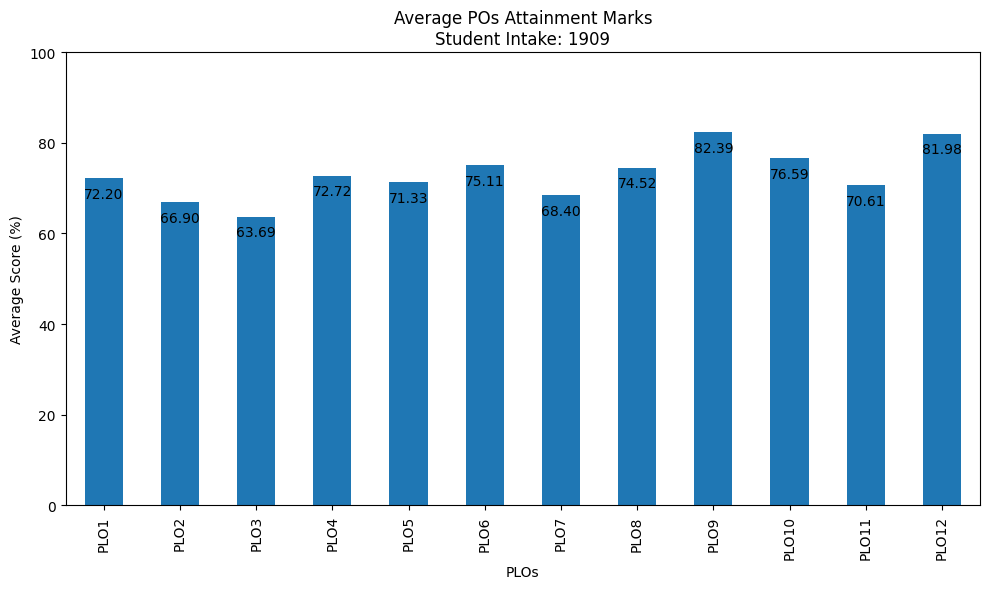

PLO sorted by average score for intake 1909:
PLO3      63.69125
PLO2     66.901579
PLO7     68.403469
PLO11    70.613265
PLO5     71.330179
PLO1     72.197544
PLO4       72.7198
PLO8      74.51898
PLO6     75.114286
PLO10    76.586531
PLO12    81.983878
PLO9     82.393958
dtype: object


PLO Averages:
PLO1     72.197544
PLO2     66.901579
PLO3      63.69125
PLO4       72.7198
PLO5     71.330179
PLO6     75.114286
PLO7     68.403469
PLO8      74.51898
PLO9     82.393958
PLO10    76.586531
PLO11    70.613265
PLO12    81.983878
dtype: object


In [40]:
def calculate_and_plot_plo_averages(intakes, specific_intake=None):
    plo_columns = [f'PLO{i}' for i in range(1, 13)]
    
    intakes_to_process = [specific_intake] if specific_intake else intakes
    
    for intake in intakes_to_process:
        po_attainment = globals()[f'po_attainment_{intake}']
        
        # Exclude 0 values before calculating the mean
        po_attainment_no_zeros = po_attainment[plo_columns].replace(0, pd.NA)
        plo_averages = po_attainment_no_zeros.mean()
        globals()[f'plo_averages_{intake}'] = plo_averages
        
        plt.figure(figsize=(10, 6))
        bars = plo_averages.plot(kind='bar')
        plt.xlabel('PLOs')
        plt.ylabel('Average Score (%)')
        plt.title(f'Average POs Attainment Marks\nStudent Intake: {intake}')
        plt.ylim(0, 100)
        for bar in bars.patches:
            plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 5, 
                     f'{bar.get_height():.2f}', ha='center', va='bottom', color='black')
        plt.tight_layout()
        
        plot_variable_name = f'plo_averages_plot_{intake}'
        globals()[plot_variable_name] = plt.gcf()
        
        # Show the plot only if a specific intake is provided
        if specific_intake:
            plt.show()
        
        # Sort and print PLO averages
        plo_averages_sorted = plo_averages.sort_values()
        print(f"PLO sorted by average score for intake {intake}:")
        print(plo_averages_sorted)

# Call the function to calculate and plot PLO averages for all intakes
calculate_and_plot_plo_averages(intakes, '1909')
print("\n\nPLO Averages:")
print(plo_averages_1909)

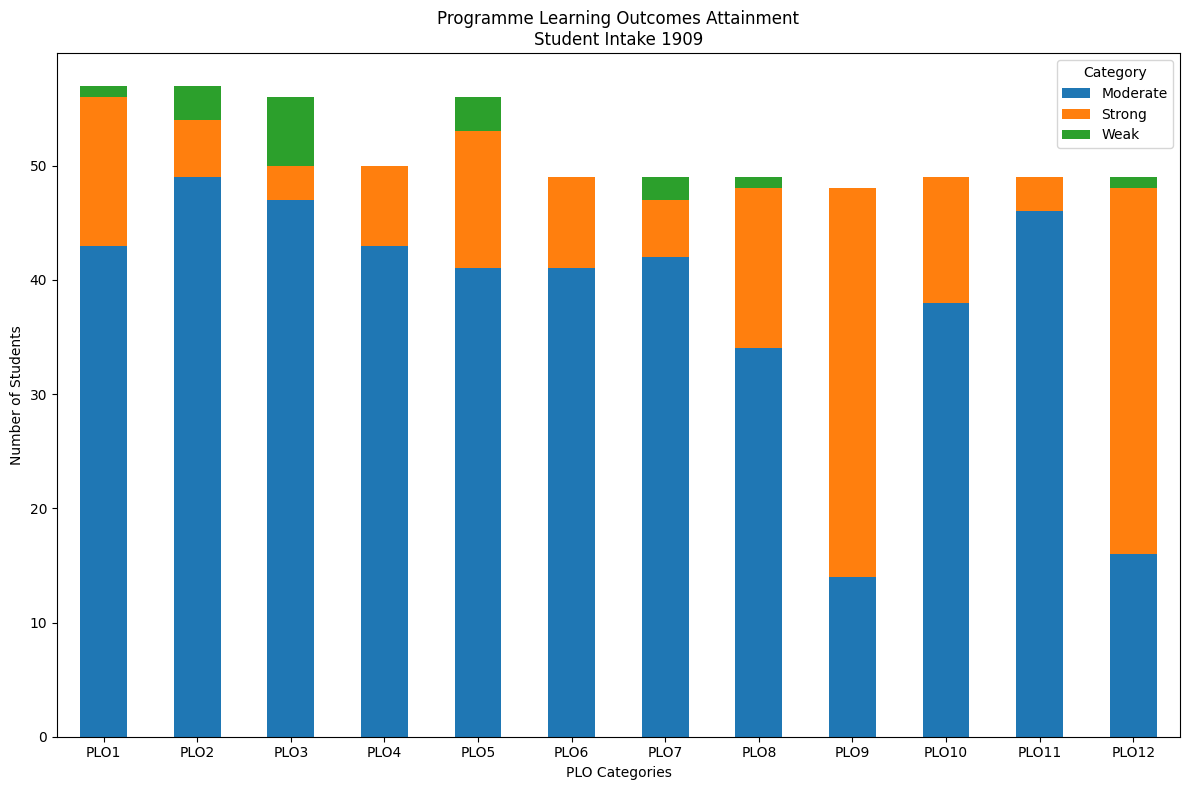

In [41]:
def calculate_and_plot_plo_categories(intakes, specific_intake=None):
    plo_category_columns = [f'PLO{i}_Category' for i in range(1, 13)]
    
    intakes_to_process = [specific_intake] if specific_intake else intakes
    
    for intake in intakes_to_process:
        po_attainment = globals()[f'po_attainment_{intake}']
        
        counts = {col: po_attainment[col].value_counts() for col in plo_category_columns}
        counts_df = pd.DataFrame(counts).fillna(0).astype(int)
        counts_df = counts_df.T
        
        counts_df = counts_df.drop(columns=['N/A'], errors='ignore')
        
        globals()[f'plo_category_counts_{intake}'] = counts_df
        
        ax = counts_df.plot(kind='bar', stacked=True, figsize=(12, 8))
        plt.title(f'Programme Learning Outcomes Attainment\nStudent Intake {intake}')
        plt.xlabel('PLO Categories')
        plt.ylabel('Number of Students')
        ax.set_xticklabels([f'PLO{i}' for i in range(1, 13)], rotation=0)
        plt.xticks(rotation=0)
        plt.legend(title='Category')
        plt.tight_layout()
        
        plot_variable_name = f'plo_category_plot_{intake}'
        globals()[plot_variable_name] = plt.gcf()
        
        # Show the plot only if a specific intake is provided
        if specific_intake:
            plt.show()

calculate_and_plot_plo_categories(intakes, '1909')

### Yearly individual display

In [42]:
# Will have like individual_display_1609_year_1, individual_display_1609_year_2, ...
def filter_by_year(df, year):
    year_str = str(year)
    return df[df['Course_Code'].str[3] == year_str].reset_index(drop=True)

years = [1, 2, 3, 4]

def get_yearly_individual_display(intakes, years):
    yearly_individualdisplay = {}
    for intake in intakes:
        combined_df = globals()[f'individual_display_{intake}_combined']
        # debug
        print(f"\nProcessing intake {intake}: combined_df shape {combined_df.shape}")
        for year in years:
            if year == 1:
                filtered_df = filter_by_year(combined_df, year)
            else:
                filtered_df = pd.concat([filter_by_year(combined_df, y) for y in range(1, year + 1)]).reset_index(drop=True)
            # Sort by Student_ID and Course_Code to group courses by student and year
            filtered_df = filtered_df.sort_values(by=['Student_ID', 'Course_Code']).reset_index(drop=True)
            yearly_individualdisplay[f'individual_display_{intake}_year_{year}'] = filtered_df

    return yearly_individualdisplay


In [43]:
years = [1, 2, 3, 4]

yearly_individualdisplay = get_yearly_individual_display(intakes, years)

for key, df in yearly_individualdisplay.items():
    print(f"{key}")
    print(df)
    print()


Processing intake 1609: combined_df shape (33, 30)

Processing intake 1709: combined_df shape (635, 30)

Processing intake 1802: combined_df shape (46, 30)

Processing intake 1804: combined_df shape (102, 30)

Processing intake 1809: combined_df shape (1000, 30)

Processing intake 1902: combined_df shape (152, 30)

Processing intake 1904: combined_df shape (432, 30)

Processing intake 1909: combined_df shape (1354, 30)

Processing intake 2002: combined_df shape (66, 30)

Processing intake 2004: combined_df shape (442, 30)

Processing intake 2009: combined_df shape (1061, 30)

Processing intake 2102: combined_df shape (2, 30)

Processing intake 2104: combined_df shape (242, 30)

Processing intake 2109: combined_df shape (746, 30)

Processing intake 2202: combined_df shape (11, 30)

Processing intake 2204: combined_df shape (31, 30)

Processing intake 2209: combined_df shape (472, 30)

Processing intake 2302: combined_df shape (4, 30)

Processing intake 2304: combined_df shape (6, 30)
i

In [44]:
def remove_identical_yearly_data(yearly_individualdisplay, intakes):
    for intake in intakes.keys():
        for year in range(4, 1, -1):
            current_year_key = f'individual_display_{intake}_year_{year}'
            previous_year_key = f'individual_display_{intake}_year_{year - 1}'
            
            # Check if both keys exist in the dictionary
            if current_year_key in yearly_individualdisplay and previous_year_key in yearly_individualdisplay:
                current_year_data = yearly_individualdisplay[current_year_key]
                previous_year_data = yearly_individualdisplay[previous_year_key]
                
                # Compare the number of rows for the current year with the previous year
                if len(current_year_data) == len(previous_year_data):
                    print(f"Removing {current_year_key} as it is identical to {previous_year_key}")
                    del yearly_individualdisplay[current_year_key]

In [45]:
remove_identical_yearly_data(yearly_individualdisplay, intakes)

Removing individual_display_2102_year_4 as it is identical to individual_display_2102_year_3
Removing individual_display_2102_year_3 as it is identical to individual_display_2102_year_2
Removing individual_display_2102_year_2 as it is identical to individual_display_2102_year_1
Removing individual_display_2109_year_4 as it is identical to individual_display_2109_year_3
Removing individual_display_2202_year_4 as it is identical to individual_display_2202_year_3
Removing individual_display_2204_year_4 as it is identical to individual_display_2204_year_3
Removing individual_display_2209_year_4 as it is identical to individual_display_2209_year_3
Removing individual_display_2209_year_3 as it is identical to individual_display_2209_year_2
Removing individual_display_2302_year_4 as it is identical to individual_display_2302_year_3
Removing individual_display_2302_year_3 as it is identical to individual_display_2302_year_2
Removing individual_display_2302_year_2 as it is identical to individu

In [46]:
print(yearly_individualdisplay['individual_display_2109_year_3'])

     Student_ID          Name Course_Code                Course_Name  \
0    EEE2109262   Cai Xintong      COM102  Programming in Language C   
1    EEE2109262   Cai Xintong      COM103     Electronic Engineering   
2    EEE2109262   Cai Xintong      COM106     Electrical Engineering   
3    EEE2109262   Cai Xintong      COM106     Electrical Engineering   
4    EEE2109262   Cai Xintong      COM107       Circuits and Devices   
..          ...           ...         ...                        ...   
656  TCM2109571  Jie Jianqiao      COM106     Electrical Engineering   
657  TCM2109571  Jie Jianqiao      COM107       Circuits and Devices   
658  TCM2109571  Jie Jianqiao      COM204       ENGINEERING GRAPHICS   
659  TCM2109571  Jie Jianqiao      EEE202      ENGINEERS AND SOCIETY   
660  TCM2109571  Jie Jianqiao      EEE203            Instrumentation   

    Academic_Session Credit_Value   PLO1   PLO2   PLO3  PLO4  ...  \
0             202104            3  75.00  30.67  70.67   0.0  ... 

In [47]:
# obtain the po attainment for each year

for intake in intakes:
    # Extract years dynamically from the keys of the dictionary
    years = sorted(set(int(key.split('_')[-1]) for key in yearly_individualdisplay.keys() if key.startswith(f'individual_display_{intake}_year_')))
    
    for year in years:
        key = f'individual_display_{intake}_year_{year}'
        if key in yearly_individualdisplay:
            globals()[f'po_attainment_{intake}_year_{year}'] = calculate_po_attainment(yearly_individualdisplay[key])

# The above makes po_attainment_1609_year_1, po_attainment_1609_year_2, ... po_attainment_1609_year_4, po_attainment_1709_year_1, ...

Processing column: PLO1, data type: float64
Processing column: PLO2, data type: float64
Processing column: PLO3, data type: float64
Processing column: PLO4, data type: float64
Processing column: PLO5, data type: float64
Processing column: PLO6, data type: float64
Processing column: PLO7, data type: float64
Processing column: PLO8, data type: float64
Processing column: PLO9, data type: float64
Processing column: PLO10, data type: float64
Processing column: PLO11, data type: float64
Processing column: PLO12, data type: float64
Processing column: PLO1, data type: float64
Processing column: PLO2, data type: float64
Processing column: PLO3, data type: float64
Processing column: PLO4, data type: float64
Processing column: PLO5, data type: float64
Processing column: PLO6, data type: float64
Processing column: PLO7, data type: float64
Processing column: PLO8, data type: float64
Processing column: PLO9, data type: float64
Processing column: PLO10, data type: float64
Processing column: PLO11, da

# Model with hyperparameter tuning
### Data preparation for model

In [48]:
data_list = []

# Combine all data from different intakes, and academic year (year 1, year 2, etc.)
    # Combined data for model training
for intake in intakes:
    yearly_data = []
    for key in yearly_individualdisplay.keys():
        if key.startswith(f'individual_display_{intake}_year_'):
            df_year = yearly_individualdisplay[key]
            year = int(key.split('_')[-1])
            # Add a column to indicate the year and intake
            df_year['Year'] = year
            df_year['Intake'] = intake
            # Append to the yearly data list
            yearly_data.append(df_year)
    # If the data for the intake exists, process it
    if yearly_data:
        # Concatenate yearly data for the intake
        df_intake = pd.concat(yearly_data, ignore_index=True)
        # Append to the main data list
        data_list.append(df_intake)

all_data = pd.concat(data_list, ignore_index=True)

def convert_percentage_to_float(df, columns):
    for column in columns:
        if df[column].dtype == 'object':
            df[column] = df[column].str.rstrip('%').astype(float) / 100.0
        df[column] = df[column].fillna(0.0)
    return df

plo_columns = [f'PLO{i}' for i in range(1, 13)]

# Convert percentage strings to float in all_data
all_data = convert_percentage_to_float(all_data, plo_columns)

# One-hot encode the course codes
encoder = OneHotEncoder(sparse_output=False)
course_codes_encoded = encoder.fit_transform(all_data[['Course_Code']])
course_code_columns = encoder.get_feature_names_out(['Course_Code'])
course_codes_df = pd.DataFrame(course_codes_encoded, columns=course_code_columns)
joblib.dump(encoder, 'onehot_encoder.save')

# Combine the encoded course codes with the original data
all_data = pd.concat([all_data, course_codes_df], axis=1)

# Pivot the data to have PLO attainments over years for each student
pivot_data = all_data.pivot_table(index=['Student_ID', 'Name', 'Intake'], columns='Year', values=plo_columns + list(course_code_columns))

# Flatten the multi-level columns
pivot_data.columns = [f'{col}_Y{year}' for col, year in pivot_data.columns]

# Reset index to make 'Student_ID', 'Name', and 'Intake' become regular columns again
pivot_data.reset_index(inplace=True)

# Features: PLOs and course codes from available years
available_years = sorted(set(int(col.split('_Y')[-1]) for col in pivot_data.columns if '_Y' in col))
feature_years = available_years[:-1]  # All years except the last one
target_year = available_years[-1]  # The last available year

# Create feature and target column names
features = [f'PLO{i}_Y{year}' for year in feature_years for i in range(1, 13)] + [f'{col}_Y{year}' for year in feature_years for col in course_code_columns]
target = [f'PLO{i}_Y{target_year}' for i in range(1, 13)]

# Drop rows with missing target data (students who don't have Year 4 data)
pivot_data = pivot_data.dropna(subset=target)

# Fill missing values in features with zeros (if any)
pivot_data[features] = pivot_data[features].fillna(0.0)

# Prepare X and y
X = pivot_data[features].values
y = pivot_data[target].values

# Reshape X to (samples, timesteps, features_per_timestep)
# There are len(feature_years) timesteps (Years 1-3) and 12 PLOs + course codes per timestep
X = X.reshape(X.shape[0], len(feature_years), len(features) // len(feature_years))  # (samples, timesteps, features)

# Split into training and test sets
X_train_full, X_test, y_train_full, y_test, idx_train_full, idx_test = train_test_split(
    X, y, pivot_data.index.values, test_size=0.2, random_state=42)

# split to training and validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42)

# scale features across all timesteps and samples
X_train_shape = X_train.shape
X_val_shape = X_val.shape
X_test_shape = X_test.shape

# Reshape to 2D for scaling
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_val_flat = X_val.reshape(-1, X_val_shape[2])
X_test_flat = X_test.reshape(-1, X_test_shape[2])

# Initialize scalers
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scaler on training data
X_train_flat_scaled = scaler_X.fit_transform(X_train_flat)
y_train_scaled = scaler_y.fit_transform(y_train)

# Save the fitted scalers using joblib
joblib.dump(scaler_X, 'scaler_X.save')
joblib.dump(scaler_y, 'scaler_y.save')

# Transform validation and test data
X_val_flat_scaled = scaler_X.transform(X_val_flat)
X_test_flat_scaled = scaler_X.transform(X_test_flat)
y_val_scaled = scaler_y.transform(y_val)
y_test_scaled = scaler_y.transform(y_test)

# Reshape back to 3D
X_train_scaled = X_train_flat_scaled.reshape(X_train_shape)
X_val_scaled = X_val_flat_scaled.reshape(X_val_shape)
X_test_scaled = X_test_flat_scaled.reshape(X_test_shape)

### Model with randomsearch hyperparameter tuning

In [49]:
def build_model(hp):
    model = Sequential()
    # tuning
    hp_units_1 = hp.Int('units_1', min_value=32, max_value=128, step=32)
    model.add(Bidirectional(LSTM(units=hp_units_1, return_sequences=True, kernel_regularizer=l2(0.001)), input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(hp.Float('dropout_rate_1', min_value=0.1, max_value=0.5, step=0.1)))

    hp_units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    model.add(Bidirectional(LSTM(units=hp_units_2, kernel_regularizer=l2(0.001))))
    model.add(Dropout(hp.Float('dropout_rate_2', min_value=0.1, max_value=0.5, step=0.1)))
    
    hp_dense_units = hp.Int('dense_units', min_value=32, max_value=128, step=32)
    model.add(Dense(units=hp_dense_units, activation='relu', kernel_regularizer=l2(0.001)))
    model.add(Dense(12, activation='linear'))
    
    model.compile(optimizer='adam', loss='mse')
    return model

tuner = kt.GridSearch(  # GridSearch or RandomSearch
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='plo_prediction')

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train_scaled, y_train_scaled,
             epochs=50,
             validation_data=(X_val_scaled, y_val_scaled),
             callbacks=[early_stopping])

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units_1')}, 
the second LSTM layer is {best_hps.get('units_2')}, the number of units in the Dense layer is {best_hps.get('dense_units')}, 
and the dropout rates are {best_hps.get('dropout_rate_1')} and {best_hps.get('dropout_rate_2')}.
""")

# Build, train, and save the model with the optimal hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=16,
                    validation_data=(X_val_scaled, y_val_scaled), callbacks=[early_stopping])
model.save('plo_prediction_model.keras')

Reloading Tuner from my_dir\plo_prediction\tuner0.json

The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 32, 
the second LSTM layer is 32, the number of units in the Dense layer is 128, 
and the dropout rates are 0.1 and 0.1.

Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 1.3892 - val_loss: 1.4910
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1819 - val_loss: 1.3780
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0191 - val_loss: 1.2344
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9337 - val_loss: 1.0561
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8517 - val_loss: 0.8239
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7614 - val_loss: 0.6949
Epoch 7/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6109 - val_loss: 0.6586
Epoch 8/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5392 - val_loss: 0.6142
Epoch 9/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - los

### Model evaluation (test set)

In [50]:
test_loss = model.evaluate(X_test_scaled, y_test_scaled)
print(f'Test Loss: {test_loss}')

# Predict the PLOs for the test set
y_pred_scaled = model.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# Create a DataFrame to display the results with Course_Code and Academic Year
results = pd.DataFrame({
    'Student_ID': pivot_data.loc[idx_test, 'Student_ID'].values,
    'Name': pivot_data.loc[idx_test, 'Name'].values
})

# Add Actual and Predicted PLOs to the results DataFrame
for i in range(1, 13):
    results[f'Actual_PLO{i}'] = y_test[:, i - 1]
    results[f'Predicted_PLO{i}'] = y_pred[:, i - 1]

print(results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1945 
Test Loss: 0.19588612020015717
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
    Student_ID                       Name  Actual_PLO1  Predicted_PLO1  \
0   EEE1904721              Kheng Ee Hern    35.957500       36.190422   
1   EEE2009223                  Hu Zhetao    19.498261       26.133219   
2   EEE1709354                 Tao Yingge    22.524545       23.453115   
3   EEE1909234                    Li Yike    30.280000       26.178719   
4   EEE1904724               Lee Yan Kang    35.943750       35.958435   
5   EEE1909262                Zhang Kexin    33.903846       34.290588   
6   EEE2009245                    Yin Yue    25.656400       30.020401   
7   EEE1909239                Liu Haisong    32.620769       33.140697   
8   EEE1709440                 Yang Jinni    22.956364       23.305550   
9   EEE1809163            Jiang Pengcheng    34.838696       33.449356   
10  EEE1909228                Chen Yuxuan    28.785000       31

Classification metrics

In [51]:
pd.set_option('display.max_columns', None)

In [52]:
def categorize_percentage(percentage):
    if 80 <= percentage <= 100:
        return 'Strong'
    elif 50 <= percentage < 80:
        return 'Moderate'
    else:
        return 'Weak'

results_categorical_copy = results.copy()
for i in range(1, 13):
    actual_col = f'Actual_PLO{i}'
    predicted_col = f'Predicted_PLO{i}'
    
    # Apply the threshold function to create new categorical columns
    results_categorical_copy[f'Categorical_Actual_PLO{i}'] = results_categorical_copy[actual_col].apply(categorize_percentage)
    results_categorical_copy[f'Categorical_Predicted_PLO{i}'] = results_categorical_copy[predicted_col].apply(categorize_percentage)

results_categorical_copy

,Student_ID,Name,Actual_PLO1,Predicted_PLO1,Actual_PLO2,Predicted_PLO2,Actual_PLO3,Predicted_PLO3,Actual_PLO4,Predicted_PLO4,Actual_PLO5,Predicted_PLO5,Actual_PLO6,Predicted_PLO6,Actual_PLO7,Predicted_PLO7,Actual_PLO8,Predicted_PLO8,Actual_PLO9,Predicted_PLO9,Actual_PLO10,Predicted_PLO10,Actual_PLO11,Predicted_PLO11,Actual_PLO12,Predicted_PLO12,Categorical_Actual_PLO1,Categorical_Predicted_PLO1,Categorical_Actual_PLO2,Categorical_Predicted_PLO2,Categorical_Actual_PLO3,Categorical_Predicted_PLO3,Categorical_Actual_PLO4,Categorical_Predicted_PLO4,Categorical_Actual_PLO5,Categorical_Predicted_PLO5,Categorical_Actual_PLO6,Categorical_Predicted_PLO6,Categorical_Actual_PLO7,Categorical_Predicted_PLO7,Categorical_Actual_PLO8,Categorical_Predicted_PLO8,Categorical_Actual_PLO9,Categorical_Predicted_PLO9,Categorical_Actual_PLO10,Categorical_Predicted_PLO10,Categorical_Actual_PLO11,Categorical_Predicted_PLO11,Categorical_Actual_PLO12,Categorical_Predicted_PLO12
0,EEE1904721,Kheng Ee Hern,35.957500,36.190422,70.967083,68.159233,31.727917,31.399178,27.785417,27.185457,27.583333,25.935411,6.597083,5.881792,5.859167,6.249345,7.184583,7.091625,11.567083,11.017348,23.050417,23.098722,12.938750,13.361214,14.464583,14.362665,Weak,Weak,Moderate,Moderate,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak
1,EEE2009223,Hu Zhetao,19.498261,26.133219,45.170435,41.041012,23.905217,19.913378,19.673043,14.987175,27.763478,25.296289,6.415217,5.122566,9.043478,8.096025,4.766957,5.207431,5.978261,6.285129,14.450435,13.700686,9.130435,6.830824,5.590000,7.660265,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak
2,EEE1709354,Tao Yingge,22.524545,23.453115,42.768182,44.766495,48.870000,47.593956,20.430000,19.071291,31.132727,30.672693,7.339091,6.728294,14.598182,12.812215,7.954545,7.988366,6.818182,7.976203,27.991818,27.492613,7.101818,7.116580,9.090909,8.454945,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak
3,EEE1909234,Li Yike,30.280000,26.178719,45.055000,47.322483,22.476429,22.554298,20.212857,20.387758,21.899643,22.832960,8.114643,7.949410,8.191429,7.669019,7.923214,8.161249,9.464286,7.965453,18.336071,18.929123,9.357857,9.526334,10.586786,11.863127,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak
4,EEE1904724,Lee Yan Kang,35.943750,35.958435,65.632917,66.956795,33.856667,31.140657,26.062500,26.907694,26.282083,25.206678,6.352917,5.598725,5.859167,6.185082,6.495000,7.086459,11.487917,10.520928,23.407083,23.161201,13.664167,13.016445,14.779167,14.509433,Weak,Weak,Moderate,Moderate,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak
5,EEE1909262,Zhang Kexin,33.903846,34.290588,64.359615,63.727943,29.786538,30.060953,24.533077,25.078928,27.109615,27.491095,9.236154,8.850321,8.562692,8.432969,8.995385,9.365679,9.367308,10.445981,21.219231,21.903221,12.010000,12.033494,12.918077,13.611122,Weak,Weak,Moderate,Moderate,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak
6,EEE2009245,Yin Yue,25.656400,30.020401,47.408000,48.828094,24.745600,23.576971,17.802400,17.044083,29.852800,29.536583,5.692000,5.309886,9.173200,9.959109,3.442800,5.868498,10.222000,9.251761,17.588400,18.515100,8.300000,8.260870,9.947200,11.143707,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak
7,EEE1909239,Liu Haisong,32.620769,33.140697,59.234231,60.546322,27.165000,27.785995,21.766154,24.109243,25.502692,26.524240,8.864615,8.713933,7.798462,8.081142,9.000000,9.281749,8.641923,9.568392,20.628846,20.696650,10.878462,11.357706,12.662308,13.334499,Weak,Weak,Moderate,Moderate,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak,Weak


In [53]:
actuals = pd.concat([results_categorical_copy[f'Categorical_Actual_PLO{i}'] for i in range(1, 13)], axis=0)
predictions = pd.concat([results_categorical_copy[f'Categorical_Predicted_PLO{i}'] for i in range(1, 13)], axis=0)
accuracy = accuracy_score(actuals, predictions)
report = classification_report(actuals, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()
accuracy_row = [accuracy] + [None] * (report_df.shape[1] - 1)
report_df.loc['accuracy'] = accuracy_row

print("Overall Classification Report:")
print(report_df)

Overall Classification Report:
              precision    recall  f1-score  support
Moderate       0.866667  0.928571  0.896552     28.0
Weak           0.996764  0.993548  0.995153    620.0
accuracy       0.990741       NaN       NaN      NaN
macro avg      0.931715  0.961060  0.945853    648.0
weighted avg   0.991142  0.990741  0.990893    648.0


Scatter plot for visualization (prediction performance visualization)

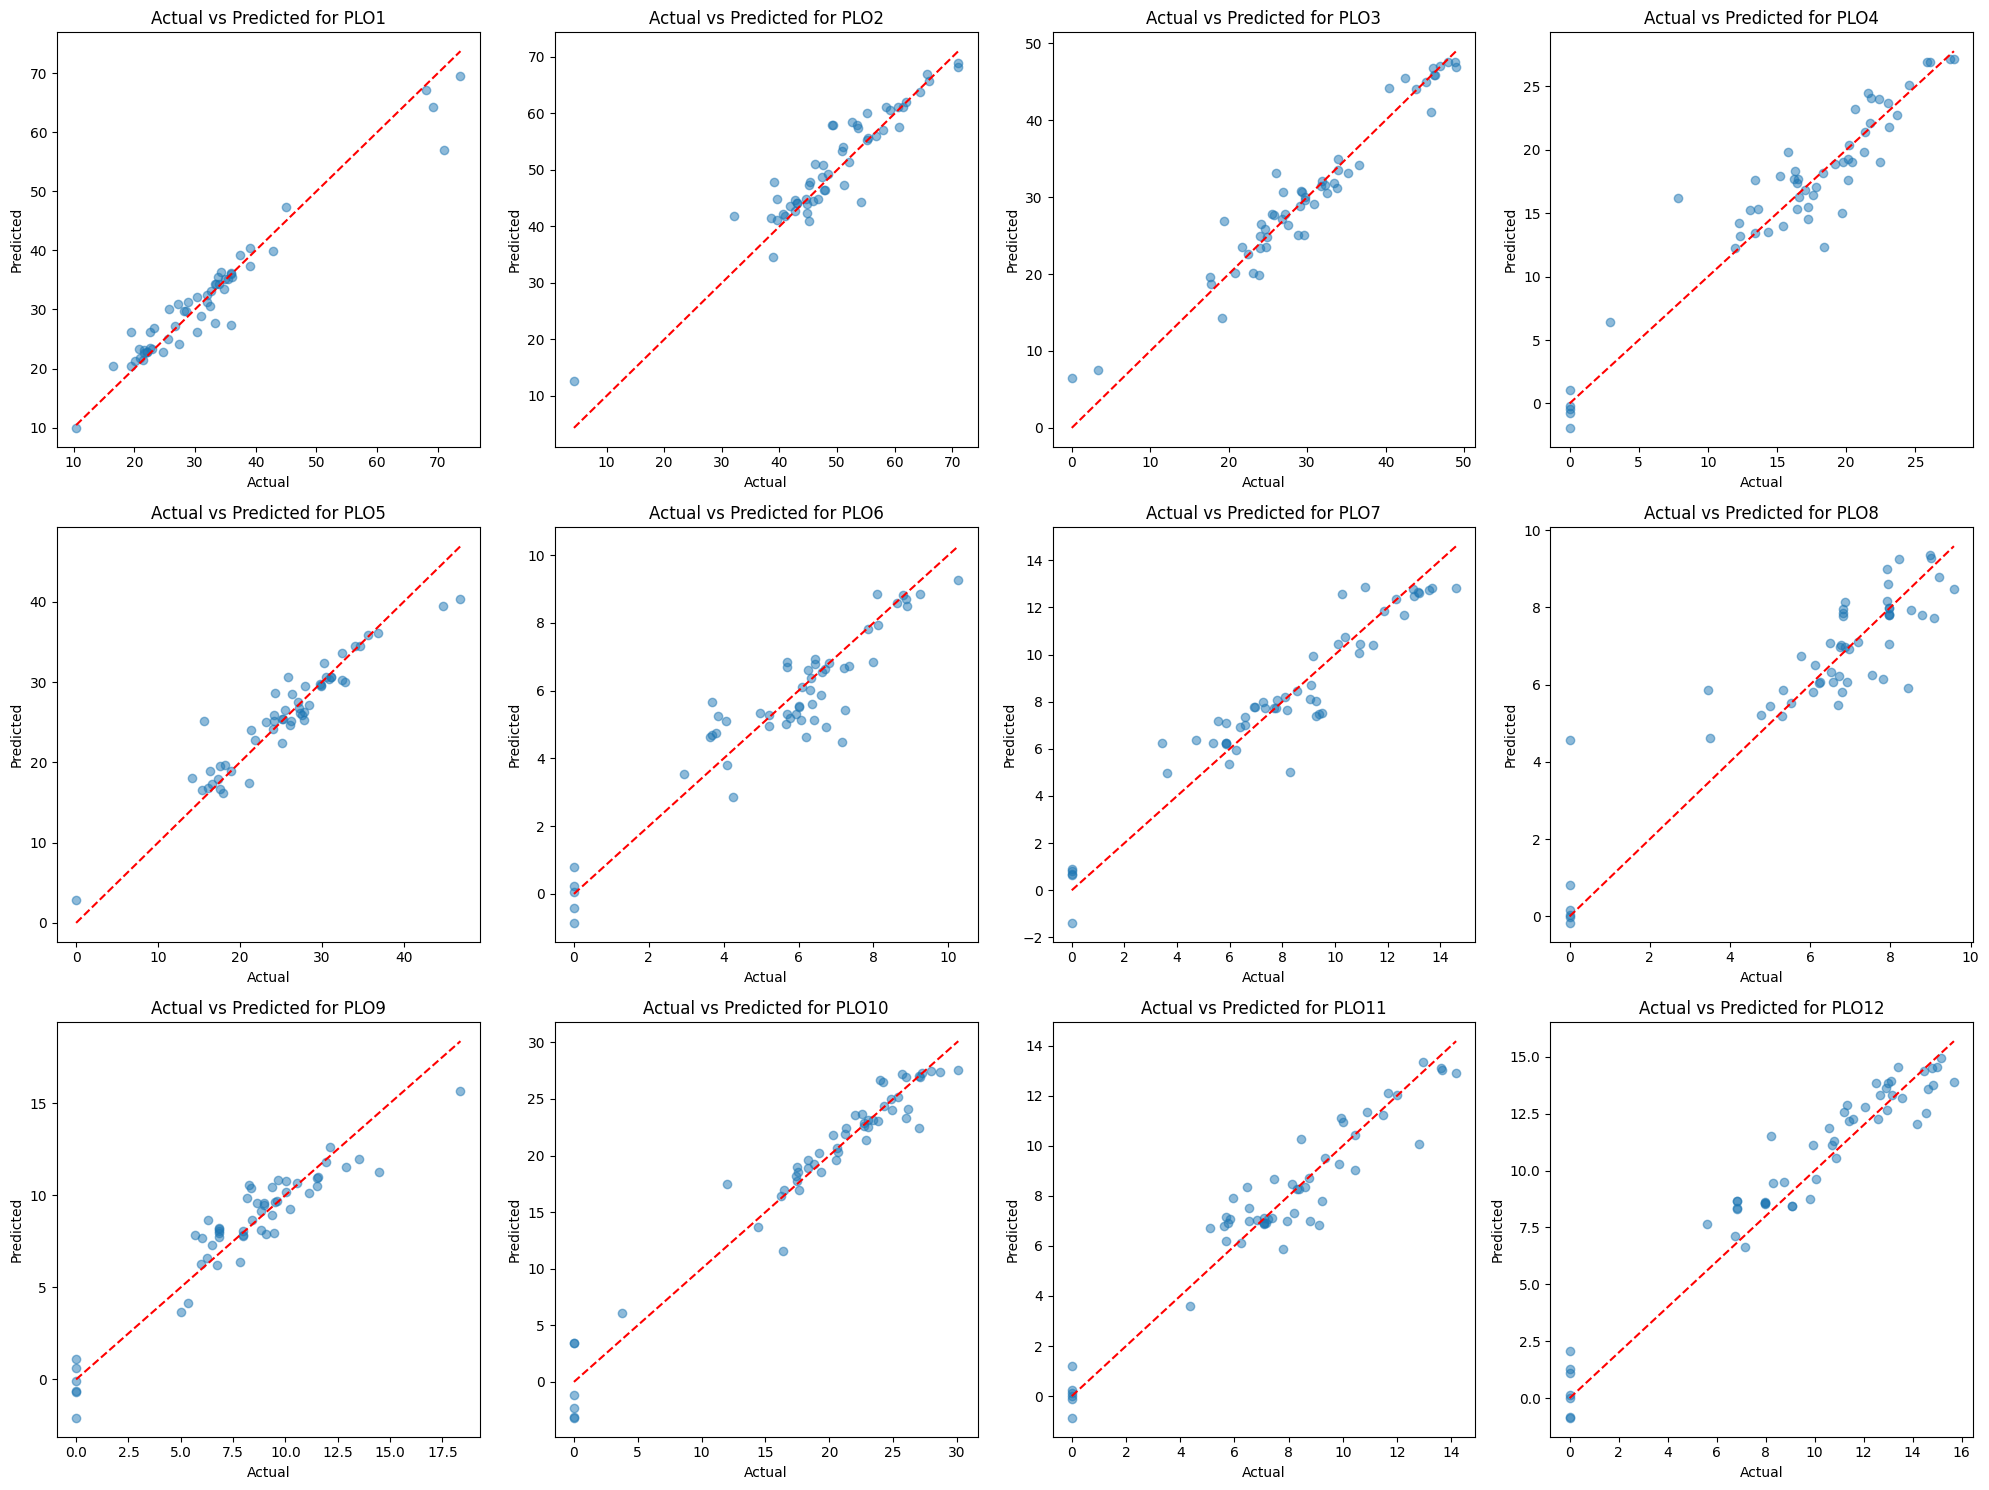

In [54]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.flatten()

for i in range(12):
    plo_number = i + 1
    axes[i].scatter(y_test[:, i], y_pred[:, i], alpha=0.5)
    axes[i].set_title(f'Actual vs Predicted for PLO{plo_number}')
    axes[i].set_xlabel('Actual')
    axes[i].set_ylabel('Predicted')
    axes[i].plot([y_test[:, i].min(), y_test[:, i].max()], [y_test[:, i].min(), y_test[:, i].max()], 'r--')  # Diagonal line

plt.tight_layout()
plt.show()


The points are distributed around the red line, means good model performance for the test set

Line plots for sample students (for prediction performance visualization)

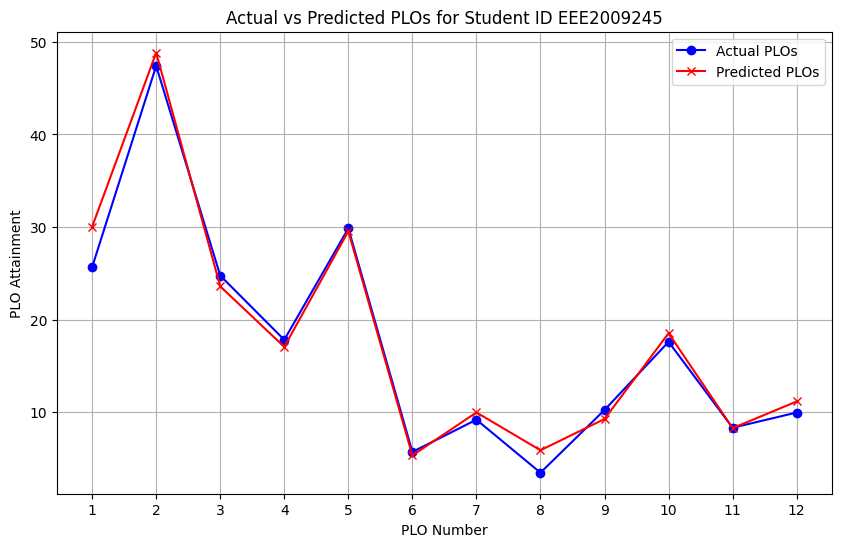

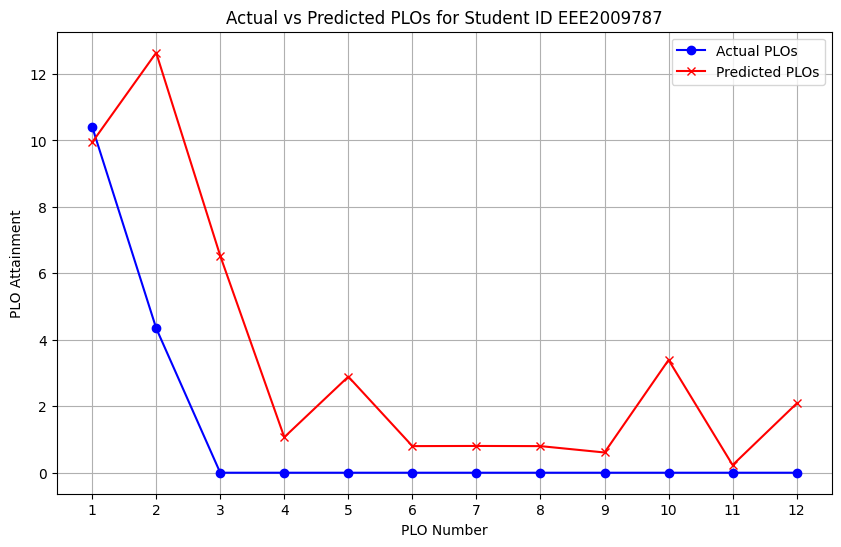

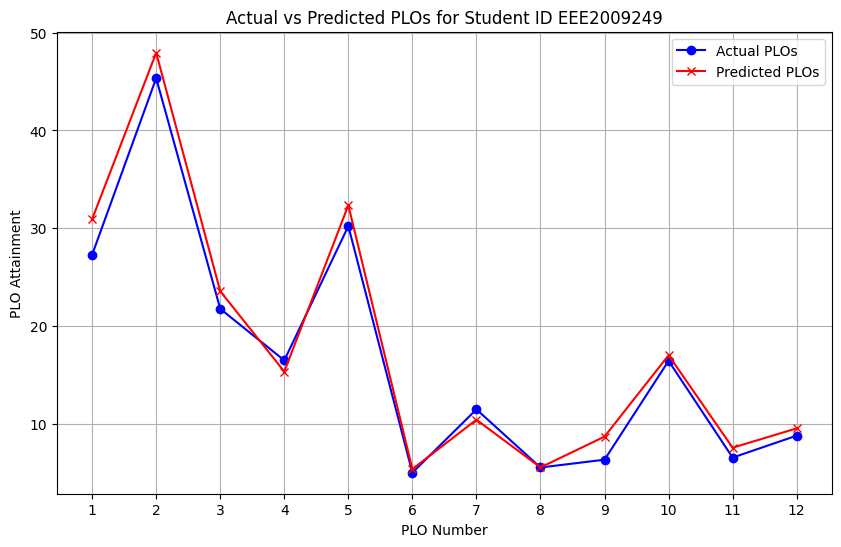

In [55]:
# plotting actual vs predicted
results.reset_index(drop=True, inplace=True)

if 'Student_ID' not in results.columns:
    raise KeyError("The 'Student_ID' column does not exist in the results DataFrame.")

num_plos = 12
plo_numbers = list(range(1, num_plos + 1))

# Generate sample indices (e.g., 3 random students)
num_samples = 3
if len(results) < num_samples:
    raise ValueError(f"Not enough samples to plot. The DataFrame contains only {len(results)} rows.")

sample_indices = random.sample(range(len(results)), num_samples)

for idx in sample_indices:
    try:
        # Access 'Student_ID'
        student_id = results.iloc[idx]['Student_ID']
        
        # Extract Actual PLOs
        actual_plos = results.iloc[idx][[f'Actual_PLO{i}' for i in plo_numbers]].tolist()
        
        # Extract Predicted PLOs
        predicted_plos = results.iloc[idx][[f'Predicted_PLO{i}' for i in plo_numbers]].tolist()
        
        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(plo_numbers, actual_plos, marker='o', label='Actual PLOs', color='blue')
        plt.plot(plo_numbers, predicted_plos, marker='x', label='Predicted PLOs', color='red')
        plt.title(f'Actual vs Predicted PLOs for Student ID {student_id}')
        plt.xlabel('PLO Number')
        plt.ylabel('PLO Attainment')
        plt.xticks(plo_numbers)
        plt.legend()
        plt.grid(True)
        plt.show()
        
    except KeyError as e:
        print(f"KeyError: {e} for index {idx}. Please check if all PLO columns exist.")
    except IndexError:
        print(f"IndexError: Index {idx} is out of bounds for the results DataFrame.")
    except Exception as e:
        print(f"An unexpected error occurred for index {idx}: {e}")


In [56]:
print(results)

    Student_ID                       Name  Actual_PLO1  Predicted_PLO1  \
0   EEE1904721              Kheng Ee Hern    35.957500       36.190422   
1   EEE2009223                  Hu Zhetao    19.498261       26.133219   
2   EEE1709354                 Tao Yingge    22.524545       23.453115   
3   EEE1909234                    Li Yike    30.280000       26.178719   
4   EEE1904724               Lee Yan Kang    35.943750       35.958435   
5   EEE1909262                Zhang Kexin    33.903846       34.290588   
6   EEE2009245                    Yin Yue    25.656400       30.020401   
7   EEE1909239                Liu Haisong    32.620769       33.140697   
8   EEE1709440                 Yang Jinni    22.956364       23.305550   
9   EEE1809163            Jiang Pengcheng    34.838696       33.449356   
10  EEE1909228                Chen Yuxuan    28.785000       31.198187   
11  EEE1809181                Xie Lanqing    28.263043       29.700954   
12  EEE1809178              Wang Jiach

Error distribution histogram (for prediction performance visualization)

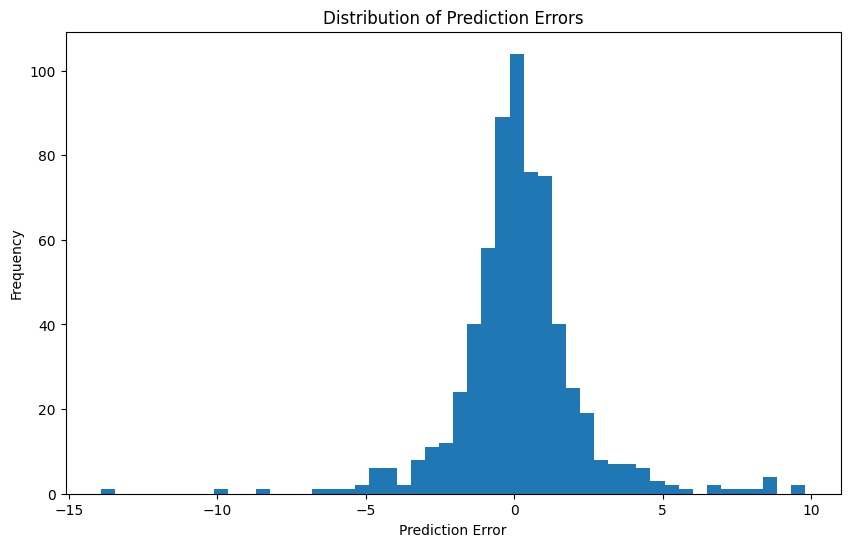

In [57]:
errors = y_pred - y_test
plt.figure(figsize=(10, 6))
plt.hist(errors.flatten(), bins=50)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.show()


### Metrics

In [58]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae:.4f}')
print(f'Mean Squared Error: {mse:.4f}')
print(f'Root Mean Squared Error: {rmse:.4f}')
print(f'R^2 Score: {r2:.4f}')

Mean Absolute Error: 1.3783
Mean Squared Error: 4.4968
Root Mean Squared Error: 2.1206
R^2 Score: 0.9028


#### Metrics individually each PLO

In [59]:
for i in range(12):
    plo_number = i + 1
    actual = y_test[:, i]
    predicted = y_pred[:, i]
    mae = mean_absolute_error(actual, predicted)
    mse = mean_squared_error(actual, predicted)
    r2 = r2_score(actual, predicted)
    print(f'PLO{plo_number}: MAE={mae:.4f}, MSE={mse:.4f}, R²={r2:.4f}')


PLO1: MAE=2.1583, MSE=10.3480, R²=0.9379
PLO2: MAE=2.8196, MSE=14.8770, R²=0.8691
PLO3: MAE=1.9052, MSE=7.0063, R²=0.9359
PLO4: MAE=1.6360, MSE=5.1680, R²=0.8951
PLO5: MAE=1.7203, MSE=6.1058, R²=0.8985
PLO6: MAE=0.6774, MSE=0.7862, R²=0.8628
PLO7: MAE=0.8793, MSE=1.2664, R²=0.9088
PLO8: MAE=0.7001, MSE=1.0903, R²=0.8338
PLO9: MAE=0.9828, MSE=1.4905, R²=0.8930
PLO10: MAE=1.3415, MSE=3.4469, R²=0.9483
PLO11: MAE=0.7737, MSE=1.0636, R²=0.9145
PLO12: MAE=0.9452, MSE=1.3131, R²=0.9359


### Training, testing, and validation loss
- To detect overfitting
    - If the training loss continues to decrease while the validation loss starts increasing, it's an indication of overfitting.
    - If the model performs significantly better on the training data than on the test data, overfitting may have occurred.

### Model performance on train and test (test whether overfitting or not)

In [60]:
# training data
y_train_pred_scaled = model.predict(X_train_scaled)
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled)

mae_train = mean_absolute_error(y_train, y_train_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_train, y_train_pred)

print("Training Data Metrics:")
print(f"Mean Absolute Error: {mae_train:.4f}")
print(f"Mean Squared Error: {mse_train:.4f}")
print(f"Root Mean Squared Error: {rmse_train:.4f}")
print(f"R^2 Score: {r2_train:.4f}")

# Evaluate on test data
y_test_pred_scaled = model.predict(X_test_scaled)
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled)

mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\nTest Data Metrics:")
print(f"Mean Absolute Error: {mae_test:.4f}")
print(f"Mean Squared Error: {mse_test:.4f}")
print(f"Root Mean Squared Error: {rmse_test:.4f}")
print(f"R^2 Score: {r2_test:.4f}")


6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training Data Metrics:
Mean Absolute Error: 1.1364
Mean Squared Error: 2.7443
Root Mean Squared Error: 1.6566
R^2 Score: 0.9236
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Test Data Metrics:
Mean Absolute Error: 1.3783
Mean Squared Error: 4.4968
Root Mean Squared Error: 2.1206
R^2 Score: 0.9028


If training metrics are significantly better than test metrics, the model might be overfitting.

But here, the training and test metrics are almost the same, so the model is not overfitting.

### Plot training and validation loss

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x00000204CD97CE50>>
Traceback (most recent call last):
  File "c:\Users\mikek\anaconda3\envs\thesis_2\Lib\site-packages\ipykernel\ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


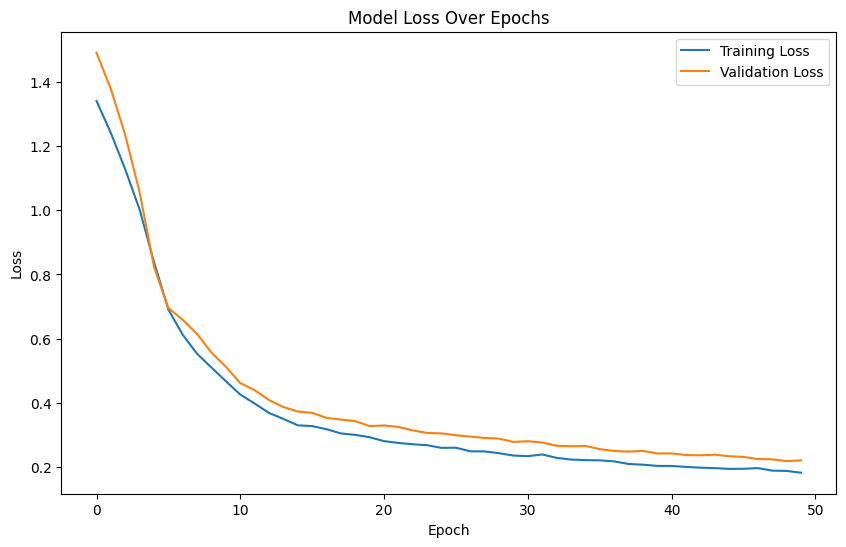

In [61]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Both training and validation loss are decreasing, so there's no overfitting

Cross validation

In [55]:
def create_model():
    # Use the best hyperparameter from Keras Tuner
    return tuner.hypermodel.build(best_hps)

# Wrap the model
model_cv = KerasRegressor(model=create_model, verbose=0)

# Perform kfold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
results = cross_val_score(model_cv, X_train_scaled, y_train_scaled, cv=kfold, scoring='neg_mean_squared_error')
print(f'Cross-Validation MSE: {-results.mean()} (+/- {results.std()})')


Cross-Validation MSE: 0.9710735976867355 (+/- 0.03218338473294669)


Monitoring and logging

In [56]:
# Create TensorBoard callback
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=1)

# Include in model.fit()
history = model.fit(X_train_scaled, y_train_scaled, epochs=100, batch_size=16,
                    validation_data=(X_val_scaled, y_val_scaled),
                    callbacks=[early_stopping, tensorboard_callback])


Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1855 - val_loss: 0.2554
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1946 - val_loss: 0.2469
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1912 - val_loss: 0.2493
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1758 - val_loss: 0.2443
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1809 - val_loss: 0.2371
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1957 - val_loss: 0.2353
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1755 - val_loss: 0.2355
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1729 - val_loss: 0.2347
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1744 - val_loss: 0.2324
Epoch 10/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1760 - val_loss: 0.2293
Epoch 11/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1707 - val_loss: 0.2286
Epoch 12/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

To view tensorboard (for monitoring and logging), run the following command in Anaconda Prompt (make sure the current environment is `(base)`)

- `cd <root>\logs` (replace root with location of this ipynb file)
- `tensorboard --logdir=./`

Then open the provided URL using browser to view the training metrics (usually `http://localhost:6006/`)

Model saving 

In [57]:
model.save('plo_prediction_model.keras')

### Predict next year PLO (new data) based on historical data

In [58]:
%run join_excel_files.py
# Create temp directory to store joined files
target_directory__newdata = tempfile.mkdtemp(prefix='OBE_newdata_')  # add prefix for easier identification
join_files('OBE Forms (New Academic Year)', target_directory__newdata, course_codes)
directory_path__newdata = target_directory__newdata

print(f"Temp dir path: {directory_path__newdata}")

All files have been copied.
Files have been filtered.
Temp dir path: C:\Users\mikek\AppData\Local\Temp\OBE_newdata_cn8i6a6f


In [59]:
# Process new OBE files
results__newdata = process_obe_forms(target_directory__newdata)
results__newdata_copy = results__newdata.copy()
all_students__newdata, student_tracking__newdata = display_all_unique_students(results__newdata)
all_students_new__newdata = standardize_allstudents_dict(all_students__newdata)
intakes__newdata = group_intakes(all_students_new__newdata)
intakes_array__newdata = make_intakes_array(intakes__newdata)


OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX done
OBE 2024-04-202404 Core-COM103 202404 ORI.xlsx
OBE 2024-04-202404 Core-COM103 202404 ORI.xlsx done
OBE 2024-04-202404 Core-COM106 202404 ORI.xlsx
OBE 2024-04-202404 Core-COM106 202404 ORI.xlsx done
OBE 2024-04-202404 Core-COM107 202404 ORI.XLSX
OBE 2024-04-202404 Core-COM107 202404 ORI.XLSX done
OBE 2024-04-202404 Core-COM203 202404 ORI.XLSX
OBE 2024-04-202404 Core-COM203 202404 ORI.XLSX done
OBE 2024-04-202404 Core-COM205 202404 ORI.XLSX
OBE 2024-04-202404 Core-COM205 202404 ORI.XLSX done
OBE 2024-04-202404 Core-COM207 202404 ORI.XLSX
OBE 2024-04-202404 Core-COM207 202404 ORI.XLSX done
OBE 2024-04-202404 Core-EEE202 202404 ORI.XLSX
OBE 2024-04-202404 Core-EEE202 202404 ORI.XLSX done
OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX
OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX done
OBE 2024-04-202404 Core-EEE301 202404 ORI.XLSX
OBE 2024-04-202404 Core-EEE301 202404 ORI.XLSX done
OBE 2024-0

In [60]:
print(type(results))
print(type(results__newdata))

<class 'numpy.ndarray'>
<class 'dict'>


In [61]:
process_individual_display(intakes__newdata, results__newdata)
calculate_po_attainment_for_all(intakes__newdata)
for intake__newdata in intakes__newdata:
    remove_duplicates_from_dict(globals()[f'individual_display_{intake__newdata}'])
clean_combined_displays(intakes__newdata)
po_attainment_combined__newdata = combine_po_attainment(intakes__newdata)

100%|██████████| 1/1 [00:00<00:00, 334.21it/s]


Student ID: EEE1902031
  File: OBE 2024-04-202404 Core-EEE302 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE405 202404 ORI.xlsx
  File: OBE 2024-04-202404 Core-EEE406 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE407 202404 ORI.XLSX
  File: OBE 2024-04-EEE302 202404 ORI.XLSX
  File: OBE 2024-04-EEE405 202404 ORI.xlsx
  File: OBE 2024-04-EEE406 202404 ORI.XLSX
  File: OBE 2024-04-EEE407 202404 ORI.XLSX


100%|██████████| 4/4 [00:00<00:00, 1333.22it/s]


Student ID: EEE1909229
  File: OBE 2024-04-202404 Core-COM203 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE411 202404 ORI.XLSX
  File: OBE 2024-04-COM203 202404 ORI.XLSX
  File: OBE 2024-04-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-EEE411 202404 ORI.XLSX
Student ID: MBT1909428
  File: OBE 2024-04-202404 Core-COM205 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE305 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE308 202404 ORI.xlsx
  File: OBE 2024-04-8.2 OBE Analysis EEE305.XLSX
  File: OBE 2024-04-COM205 202404 ORI.XLSX
  File: OBE 2024-04-EEE308 202404 ORI.xlsx
  File: OBE 2024-04-EEE310 OBE Template v3.1-Industrial Training_202402.XLSX
Student ID: EEE1909688
  File: OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE305 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE308 202404 ORI.xlsx
  File: OBE 2024-04-202404 Core-EEE319 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE405 2

100%|██████████| 2/2 [00:00<00:00, 2000.14it/s]


Student ID: EEE2004299
  File: OBE 2024-04-202404 Core-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE319 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE411 202404 ORI.XLSX
  File: OBE 2024-04-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-EEE319 202404 ORI.XLSX
  File: OBE 2024-04-EEE411 202404 ORI.XLSX
Student ID: EEE2004300
  File: OBE 2024-04-202404 Core-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE406 202404 ORI.XLSX
  File: OBE 2024-04-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-EEE310 OBE Template v3.1-Industrial Training_202402.XLSX
  File: OBE 2024-04-EEE406 202404 ORI.XLSX


100%|██████████| 41/41 [00:00<00:00, 2928.78it/s]


Student ID: EEE2009223
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE405 202404 ORI.xlsx
  File: OBE 2024-04-COM102 202404 ORI.XLSX
  File: OBE 2024-04-EEE310 OBE Template v3.1-Industrial Training_202402.XLSX
  File: OBE 2024-04-EEE405 202404 ORI.xlsx
Student ID: EEE2009211
  File: OBE 2024-04-202404 Core-COM103 202404 ORI.xlsx
  File: OBE 2024-04-202404 Core-EEE308 202404 ORI.xlsx
  File: OBE 2024-04-202404 Core-EEE405 202404 ORI.xlsx
  File: OBE 2024-04-202404 Core-EEE406 202404 ORI.XLSX
  File: OBE 2024-04-COM103 202404 ORI.xlsx
  File: OBE 2024-04-EEE308 202404 ORI.xlsx
  File: OBE 2024-04-EEE405 202404 ORI.xlsx
  File: OBE 2024-04-EEE406 202404 ORI.XLSX
Student ID: EEE2009241
  File: OBE 2024-04-202404 Core-COM103 202404 ORI.xlsx
  File: OBE 2024-04-202404 Core-COM106 202404 ORI.xlsx
  File: OBE 2024-04-202404 Core-COM205 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE405 202404 

100%|██████████| 11/11 [00:00<00:00, 1796.84it/s]


Student ID: AIT2104241
  File: OBE 2024-04-202404 Core-EEE302 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE304 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE316 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE319 202404 ORI.XLSX
  File: OBE 2024-04-EEE302 202404 ORI.XLSX
  File: OBE 2024-04-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-EEE304 202404 ORI.XLSX
  File: OBE 2024-04-EEE316 202404 ORI.XLSX
  File: OBE 2024-04-EEE319 202404 ORI.XLSX
Student ID: EEE2104050
  File: OBE 2024-04-202404 Core-EEE404 202404 ORI.xlsx
  File: OBE 2024-04-202404 Core-EEE406 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE407 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE411 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE414 202404 ORI.xlsx
  File: OBE 2024-04-EEE310 OBE Template v3.1-Industrial Training_202402.XLSX
  File: OBE 2024-04-EEE404 202404 ORI.xlsx
  File: OBE 2024-04-EEE406 202404 ORI.XLSX
  File: OBE 2024-04-EEE407

100%|██████████| 44/44 [00:00<00:00, 1238.15it/s]


Student ID: TCM2109571
  File: OBE 2024-04-202404 Core-COM203 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-COM207 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE301 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE313 202404 ORI.XLSX
  File: OBE 2024-04-COM203 202404 ORI.XLSX
  File: OBE 2024-04-COM207 202404 ORI.XLSX
  File: OBE 2024-04-EEE301 202404 ORI.XLSX
  File: OBE 2024-04-EEE313 202404 ORI.XLSX
Student ID: EEE2109276
  File: OBE 2024-04-202404 Core-COM205 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE309 202404 ORI.XLSX
  File: OBE 2024-04-COM205 202404 ORI.XLSX
  File: OBE 2024-04-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-EEE309 202404 ORI.XLSX
Student ID: EEE2109294
  File: OBE 2024-04-202404 Core-COM205 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE305 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE308 202404 ORI.xlsx
  File: OBE 2024-04-20240

100%|██████████| 1/1 [00:00<00:00, 664.29it/s]


Student ID: EEE2202055
  File: OBE 2024-04-202404 Core-EEE302 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE304 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE316 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE319 202404 ORI.XLSX
  File: OBE 2024-04-EEE302 202404 ORI.XLSX
  File: OBE 2024-04-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-EEE304 202404 ORI.XLSX
  File: OBE 2024-04-EEE316 202404 ORI.XLSX
  File: OBE 2024-04-EEE319 202404 ORI.XLSX


100%|██████████| 2/2 [00:00<00:00, 1000.19it/s]


Student ID: EEE2204254
  File: OBE 2024-04-202404 Core-EEE302 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE304 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE316 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE319 202404 ORI.XLSX
  File: OBE 2024-04-EEE302 202404 ORI.XLSX
  File: OBE 2024-04-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-EEE304 202404 ORI.XLSX
  File: OBE 2024-04-EEE316 202404 ORI.XLSX
  File: OBE 2024-04-EEE319 202404 ORI.XLSX
Student ID: EEE2204255
  File: OBE 2024-04-202404 Core-EEE302 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE304 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE316 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE319 202404 ORI.XLSX
  File: OBE 2024-04-EEE302 202404 ORI.XLSX
  File: OBE 2024-04-EEE303 202404 ORI.XLSX
  File: OBE 2024-04-EEE304 202404 ORI.XLSX
  File: OBE 2024-04-EEE316 202404 ORI.XLSX
  File: OBE 2024-

100%|██████████| 55/55 [00:00<00:00, 2761.16it/s]


Student ID: EEE2209019
  File: OBE 2024-04-202404 Core-COM203 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-COM207 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE301 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE313 202404 ORI.XLSX
  File: OBE 2024-04-COM203 202404 ORI.XLSX
  File: OBE 2024-04-COM207 202404 ORI.XLSX
  File: OBE 2024-04-EEE301 202404 ORI.XLSX
  File: OBE 2024-04-EEE313 202404 ORI.XLSX
Student ID: EEE2209020
  File: OBE 2024-04-202404 Core-COM203 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-COM207 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE301 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE313 202404 ORI.XLSX
  File: OBE 2024-04-COM203 202404 ORI.XLSX
  File: OBE 2024-04-COM207 202404 ORI.XLSX
  File: OBE 2024-04-EEE301 202404 ORI.XLSX
  File: OBE 2024-04-EEE313 202404 ORI.XLSX
Student ID: EEE2209021
  File: OBE 2024-04-202404 Core-COM203 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-COM207 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE30

100%|██████████| 2/2 [00:00<00:00, 2001.10it/s]


Student ID: EEE2302035
  File: OBE 2024-04-202404 Core-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-EEE202 202404 ORI.XLSX
Student ID: EEE2302110
  File: OBE 2024-04-202404 Core-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-EEE203 202404 ORI.XLSX


100%|██████████| 6/6 [00:00<00:00, 2997.36it/s]


Student ID: EEE2304142
  File: OBE 2024-04-202404 Core-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-EEE203 202404 ORI.XLSX
Student ID: EEE2304143
  File: OBE 2024-04-202404 Core-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-EEE203 202404 ORI.XLSX
Student ID: EEE2304296
  File: OBE 2024-04-202404 Core-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-EEE203 202404 ORI.XLSX
Student ID: EEE2304363
  File: OBE 2024-04-202404 Core-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE203 202404 ORI.XLSX
  File: OBE 2024-04-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-EEE203 202404 ORI.XLSX
Student ID: EEE2304411
  File: OBE 2024-04-202404 Core-EEE202 202404 ORI.XLSX
  File: OBE 2024-04-202404 Core-EEE203 202404 

100%|██████████| 5/5 [00:00<00:00, 2499.59it/s]


Student ID: CME2309114
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: CME2309120
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: CME2309124
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: MBT2309468
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: MEC2309480
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX


100%|██████████| 7/7 [00:00<00:00, 2335.54it/s]


Student ID: EEE2402035
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2402128
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2402129
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2402130
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2402191
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2402192
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2402246
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX


100%|██████████| 11/11 [00:00<00:00, 2204.57it/s]


Student ID: EEE2404148
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2404149
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2404150
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2404286
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2404387
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2404388
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2404463
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2404473
  File: OBE 2024-04-202404 Core-COM102 202404 ORI.XLSX
  File: OBE 2024-04-COM102 202404 ORI.XLSX
Student ID: EEE2404510
  File: O

100%|██████████| 11/11 [00:00<00:00, 195.81it/s]


Processing column: PLO1, data type: object
Processing column: PLO2, data type: object
Processing column: PLO3, data type: object
Processing column: PLO4, data type: object
Processing column: PLO5, data type: object
Processing column: PLO6, data type: object
Processing column: PLO7, data type: object
Processing column: PLO8, data type: object
Processing column: PLO9, data type: object
Processing column: PLO10, data type: object
Processing column: PLO11, data type: object
Processing column: PLO12, data type: object
Processing column: PLO1, data type: object
Processing column: PLO2, data type: object
Processing column: PLO3, data type: object
Processing column: PLO4, data type: object
Processing column: PLO5, data type: object
Processing column: PLO6, data type: object
Processing column: PLO7, data type: object
Processing column: PLO8, data type: object
Processing column: PLO9, data type: object
Processing column: PLO10, data type: object
Processing column: PLO11, data type: object
Proces

In [62]:
individual_display_allintakes_combined__newdata = combine_individual_display_allintakes(intakes__newdata)
individual_display_allintakes_combined__newdata.set_index('Student_ID', inplace=True)


In [63]:
# combine individual_display_allintakes_combined (old) with individual_display_allintakes_combined__newdata (new)
individual_display_allintakes_combined__newdata = pd.concat([individual_display_allintakes_combined, individual_display_allintakes_combined__newdata])

intakes_plus_intakes__newdata = intakes.copy()

for intake, students in intakes__newdata.items():
    if intake in intakes_plus_intakes__newdata:
        # Combine and deduplicate student lists
        intakes_plus_intakes__newdata[intake] = list(set(
            intakes_plus_intakes__newdata[intake] + students
        ))
    else:
        # Add new intake and students
        intakes_plus_intakes__newdata[intake] = students

# Assuming individual_display_allintakes_combined__newdata has a multi-index with 'Student_ID' as the first level
# Extract 'Student_ID' values from the index
extracted_student_ids = individual_display_allintakes_combined__newdata.index.get_level_values('Student_ID')

# Create 'Intake' column by slicing 'Student_ID' values
individual_display_allintakes_combined__newdata['Intake'] = extracted_student_ids.str[3:7]

# Step 1: Create per-intake combined DataFrames from new data
for intake in intakes__newdata:
    combined_df_name = f'individual_display_{intake}_combined__newdata'
    globals()[combined_df_name] = individual_display_allintakes_combined__newdata[
        individual_display_allintakes_combined__newdata['Intake'] == str(intake)
    ].reset_index()

# Step 2: Merge per-intake combined DataFrames
for intake in intakes__newdata:
    old_df_name = f'individual_display_{intake}_combined'
    new_df_name = f'individual_display_{intake}_combined__newdata'

    if old_df_name in globals():
        globals()[old_df_name] = pd.concat(
            [globals()[old_df_name], globals()[new_df_name]],
            ignore_index=True
        )
    else:
        # If old DataFrame doesn't exist, use the new DataFrame
        globals()[old_df_name] = globals()[new_df_name]

student_entry__newdata = get_student_entry(individual_display_allintakes_combined__newdata, "EEE1804290")

In [64]:
years = [1, 2, 3, 4] 
yearly_individualdisplay_combined = get_yearly_individual_display(
    intakes_plus_intakes__newdata,
    years
)


Processing intake 1609: combined_df shape (33, 30)

Processing intake 1709: combined_df shape (635, 30)

Processing intake 1802: combined_df shape (46, 30)

Processing intake 1804: combined_df shape (102, 30)

Processing intake 1809: combined_df shape (1000, 30)

Processing intake 1902: combined_df shape (160, 31)

Processing intake 1904: combined_df shape (432, 30)

Processing intake 1909: combined_df shape (1386, 31)

Processing intake 2002: combined_df shape (66, 30)

Processing intake 2004: combined_df shape (454, 31)

Processing intake 2009: combined_df shape (1259, 31)

Processing intake 2102: combined_df shape (2, 30)

Processing intake 2104: combined_df shape (364, 31)

Processing intake 2109: combined_df shape (1312, 31)

Processing intake 2202: combined_df shape (21, 31)

Processing intake 2204: combined_df shape (51, 31)

Processing intake 2209: combined_df shape (900, 31)

Processing intake 2302: combined_df shape (10, 31)

Processing intake 2304: combined_df shape (30, 31

In [65]:
print("\nCombined Yearly Individual Display:")
for key, df in yearly_individualdisplay_combined.items():
    unique_students = df['Student_ID'].nunique()
    print(f"{key}: {unique_students} unique students")


Combined Yearly Individual Display:
individual_display_1609_year_1: 1 unique students
individual_display_1609_year_2: 2 unique students
individual_display_1609_year_3: 2 unique students
individual_display_1609_year_4: 2 unique students
individual_display_1709_year_1: 1 unique students
individual_display_1709_year_2: 48 unique students
individual_display_1709_year_3: 50 unique students
individual_display_1709_year_4: 50 unique students
individual_display_1802_year_1: 1 unique students
individual_display_1802_year_2: 2 unique students
individual_display_1802_year_3: 3 unique students
individual_display_1802_year_4: 3 unique students
individual_display_1804_year_1: 2 unique students
individual_display_1804_year_2: 2 unique students
individual_display_1804_year_3: 6 unique students
individual_display_1804_year_4: 6 unique students
individual_display_1809_year_1: 3 unique students
individual_display_1809_year_2: 43 unique students
individual_display_1809_year_3: 43 unique students
individu

In [66]:
remove_identical_yearly_data(yearly_individualdisplay_combined, intakes__newdata)

Removing individual_display_2202_year_4 as it is identical to individual_display_2202_year_3
Removing individual_display_2204_year_4 as it is identical to individual_display_2204_year_3
Removing individual_display_2209_year_4 as it is identical to individual_display_2209_year_3
Removing individual_display_2302_year_4 as it is identical to individual_display_2302_year_3
Removing individual_display_2302_year_3 as it is identical to individual_display_2302_year_2
Removing individual_display_2304_year_4 as it is identical to individual_display_2304_year_3
Removing individual_display_2304_year_3 as it is identical to individual_display_2304_year_2
Removing individual_display_2309_year_4 as it is identical to individual_display_2309_year_3
Removing individual_display_2309_year_3 as it is identical to individual_display_2309_year_2
Removing individual_display_2309_year_2 as it is identical to individual_display_2309_year_1
Removing individual_display_2402_year_4 as it is identical to individu

In [67]:
delete_temp_directory(directory_path__newdata)

Attempt 1 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_newdata_cn8i6a6f\\OBE 2024-04-EEE316 202404 ORI.XLSX'
Attempt 2 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_newdata_cn8i6a6f\\OBE 2024-04-EEE316 202404 ORI.XLSX'
Attempt 3 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_newdata_cn8i6a6f\\OBE 2024-04-EEE316 202404 ORI.XLSX'
Failed to delete temporary directory C:\Users\mikek\AppData\Local\Temp\OBE_newdata_cn8i6a6f after 3 attempts.


Delete duplicates in yearly_individualdisplay_combined

In [68]:
for key, df in yearly_individualdisplay_combined.items():
    yearly_individualdisplay_combined[key] = df.drop_duplicates().reset_index(drop=True)

In [69]:
for intake in intakes__newdata:
    # Extract years dynamically from the keys of the dictionary
    years = sorted(set(int(key.split('_')[-1]) for key in yearly_individualdisplay_combined.keys() if key.startswith(f'individual_display_{intake}_year_')))

    for year in years:
        key = f'individual_display_{intake}_year_{year}'
        # debug
        print(f"Processing {key} in code block")
        if key in yearly_individualdisplay_combined:
            # debug
            try:
                print(yearly_individualdisplay_combined[key].dtypes)
                globals()[f'po_attainment_{intake}_year_{year}'] = calculate_po_attainment(yearly_individualdisplay_combined[key])
            except Exception as e:
                print(f"Error processing {key} with calculate_po_attainment")
                print(f"Exception: {e}")
                print(f"DataFrame causing the error:\n{yearly_individualdisplay_combined[key]}")
                raise

Processing individual_display_1902_year_1 in code block
Student_ID           object
Name                 object
Course_Code          object
Course_Name          object
Academic_Session     object
Credit_Value         object
PLO1                float64
PLO2                float64
PLO3                float64
PLO4                float64
PLO5                float64
PLO6                float64
PLO7                float64
PLO8                float64
PLO9                float64
PLO10               float64
PLO11               float64
PLO12               float64
Category_PLO1        object
Category_PLO2        object
Category_PLO3        object
Category_PLO4        object
Category_PLO5        object
Category_PLO6        object
Category_PLO7        object
Category_PLO8        object
Category_PLO9        object
Category_PLO10       object
Category_PLO11       object
Category_PLO12       object
Intake               object
dtype: object
Processing column: PLO1, data type: float64
Processing column:

In [70]:
# Verify the global variables
for intake in intakes__newdata:
    years = sorted(set(int(key.split('_')[-1]) for key in yearly_individualdisplay_combined.keys() if key.startswith(f'individual_display_{intake}_year_')))
    for year in years:
        var_name = f'po_attainment_{intake}_year_{year}'
        if var_name in globals():
            print(f'{var_name} is set')
        else:
            print(f'{var_name} is not set')

po_attainment_1902_year_1 is set
po_attainment_1902_year_2 is set
po_attainment_1902_year_3 is set
po_attainment_1902_year_4 is set
po_attainment_1909_year_1 is set
po_attainment_1909_year_2 is set
po_attainment_1909_year_3 is set
po_attainment_1909_year_4 is set
po_attainment_2004_year_1 is set
po_attainment_2004_year_2 is set
po_attainment_2004_year_3 is set
po_attainment_2004_year_4 is set
po_attainment_2009_year_1 is set
po_attainment_2009_year_2 is set
po_attainment_2009_year_3 is set
po_attainment_2009_year_4 is set
po_attainment_2104_year_1 is set
po_attainment_2104_year_2 is set
po_attainment_2104_year_3 is set
po_attainment_2104_year_4 is set
po_attainment_2109_year_1 is set
po_attainment_2109_year_2 is set
po_attainment_2109_year_3 is set
po_attainment_2109_year_4 is set
po_attainment_2202_year_1 is set
po_attainment_2202_year_2 is set
po_attainment_2202_year_3 is set
po_attainment_2204_year_1 is set
po_attainment_2204_year_2 is set
po_attainment_2204_year_3 is set
po_attainm

# Predict score for new data

In [71]:
# Load the trained model
model = load_model('plo_prediction_model.keras')

# Load saved scalers and encoder
scaler_X = joblib.load('scaler_X.save')
scaler_y = joblib.load('scaler_y.save')
encoder = joblib.load('onehot_encoder.save')  # Loaded encoder

# Function to convert percentage strings to float
def convert_percentage_to_float(df, columns):
    for column in columns:
        if df[column].dtype == 'object':
            df[column] = df[column].str.rstrip('%').astype(float) / 100.0
        df[column] = df[column].fillna(0.0)
    return df

plo_columns = [f'PLO{i}' for i in range(1, 13)]
predicted_individualdisplay_combined = {}
displayed_predictions = []

# Iterate through each intake
for intake in intakes__newdata:
    # Extract all years for the current intake
    intake_keys = [key for key in yearly_individualdisplay_combined.keys() if key.startswith(f'individual_display_{intake}_year_')]

    if not intake_keys:
        print(f'No data available for intake {intake}.')
        continue

    # Determine the available years
    available_years = []
    for key in intake_keys:
        try:
            year = int(key.split('_year_')[-1])
            available_years.append(year)
        except ValueError:
            continue

    if not available_years:
        print(f'No valid year data for intake {intake}.')
        continue

    max_year = max(available_years)
    next_year = max_year + 1

    # Prepare a list to hold data for available years
    data_list = []
    for year in range(1, max_year + 1):
        key = f'individual_display_{intake}_year_{year}'
        if key in yearly_individualdisplay_combined:
            df_year = yearly_individualdisplay_combined[key].copy()
            df_year['Year'] = year
            df_year['Intake'] = intake
            data_list.append(df_year)

    if not data_list:
        print(f'No data to predict for intake {intake}.')
        continue

    # Concatenate yearly data for the intake
    df_intake = pd.concat(data_list, ignore_index=True)

    # Convert percentage strings to float
    df_intake = convert_percentage_to_float(df_intake, plo_columns)

    # One-hot encode the course codes using the loaded encoder
    course_codes_encoded = encoder.transform(df_intake[['Course_Code']])
    all_course_code_columns = encoder.get_feature_names_out(['Course_Code'])
    course_codes_df = pd.DataFrame(course_codes_encoded, columns=all_course_code_columns)

    # Combine the encoded course codes with the original data
    df_intake = pd.concat([df_intake, course_codes_df], axis=1)

    # Ensure all course code columns are present
    missing_cols = set(all_course_code_columns) - set(course_codes_df.columns)
    for col in missing_cols:
        df_intake[col] = 0.0

    # Pivot the data to have PLO attainments over years for the current intake
    pivot_data = df_intake.pivot_table(index=['Student_ID', 'Name', 'Intake'], columns='Year', values=plo_columns + list(all_course_code_columns))

    # Flatten the multi-level columns
    pivot_data.columns = [f'{col}_Y{year}' for col, year in pivot_data.columns]

    # Reset index
    pivot_data.reset_index(inplace=True)

    # Create feature column names
    feature_years = sorted(available_years)
    features = [f'PLO{i}_Y{year}' for year in feature_years for i in range(1, 13)] + [f'{col}_Y{year}' for year in feature_years for col in all_course_code_columns]

    # Fill missing values with zeros
    pivot_data[features] = pivot_data[features].fillna(0.0)

    # Prepare X for prediction
    X = pivot_data[features].values

    # Reshape X to (samples, timesteps, features_per_timestep)
    timesteps = len(feature_years)
    features_per_timestep = len(features) // timesteps
    X = X.reshape(X.shape[0], timesteps, features_per_timestep)

    # Flatten X for scaling
    X_flat = X.reshape(-1, features_per_timestep)

    # Scale X
    X_flat_scaled = scaler_X.transform(X_flat)

    # Reshape back to 3D
    X_scaled = X_flat_scaled.reshape(X.shape[0], timesteps, features_per_timestep)

    # Make predictions
    y_pred_scaled = model.predict(X_scaled)

    # Reshape predictions to 2D
    y_pred_scaled = y_pred_scaled.reshape(-1, 12)

    # Debug, check the range of scaled predictions
    print(f'Scaled predictions min: {y_pred_scaled.min()}, max: {y_pred_scaled.max()}')

    # Inverse transform the predictions
    y_pred = scaler_y.inverse_transform(y_pred_scaled)

    # Create a DataFrame with predictions
    predicted_data = pivot_data[['Student_ID', 'Name', 'Intake']].copy()
    for i in range(1, 13):
        predicted_data[f'PLO{i}_Y{next_year}'] = y_pred[:, i - 1]

    # Store the predicted DataFrame in the new dictionary
    pred_key = f'individual_display_{intake}_year_{next_year}_predicted'
    predicted_individualdisplay_combined[pred_key] = predicted_data

    # **Skip Display for Year 5**
    # Display the predicted DataFrame
    if next_year != 5:
        print(f'Predicted DataFrame for {intake} Year {next_year}:')
        display(predicted_individualdisplay_combined[pred_key])
        displayed_predictions.append(pred_key)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step
Scaled predictions min: -5.584886074066162, max: -2.4038217067718506
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Scaled predictions min: -6.838136196136475, max: -1.4760735034942627
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Scaled predictions min: -5.859931468963623, max: -2.3022940158843994
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Scaled predictions min: -5.986063480377197, max: -1.4001634120941162
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Scaled predictions min: -5.728390693664551, max: -2.233872175216675
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Scaled predictions min: -5.67784309387207, max: -1.3571288585662842
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
Scaled predictions min: -1.4950588941574097, max: 0.2767913043498993
Predicted DataFrame for 2202 Year 4:


,Student_ID,Name,Intake,PLO1_Y4,PLO2_Y4,PLO3_Y4,PLO4_Y4,PLO5_Y4,PLO6_Y4,PLO7_Y4,PLO8_Y4,PLO9_Y4,PLO10_Y4,PLO11_Y4,PLO12_Y4
0,EEE2202055,Choombwa Warren Lweendo,2202,30.484812,40.811813,16.252254,18.975504,19.697536,2.976512,3.496984,5.948872,2.644509,11.978959,7.272648,9.584111


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Scaled predictions min: -2.0277984142303467, max: 1.9232923984527588
Predicted DataFrame for 2204 Year 4:


,Student_ID,Name,Intake,PLO1_Y4,PLO2_Y4,PLO3_Y4,PLO4_Y4,PLO5_Y4,PLO6_Y4,PLO7_Y4,PLO8_Y4,PLO9_Y4,PLO10_Y4,PLO11_Y4,PLO12_Y4
0,EEE2204254,Lee Yan Yi,2204,32.567574,39.113598,14.183959,15.568470,18.430344,2.557796,2.865427,4.714723,2.543797,9.669807,5.928358,7.994545
1,EEE2204255,Ong Zhe,2204,47.917431,61.630852,24.184856,20.885273,24.436611,2.600852,4.035341,6.043310,3.436941,10.259734,8.035686,8.552224
2,EEE2204256,Zachary Tang Ji Chung,2204,41.361126,48.567127,26.927416,5.847511,33.874340,11.595436,9.880095,8.589785,1.938548,4.511215,2.553321,0.591276


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Scaled predictions min: -3.0025854110717773, max: 3.407031536102295
Predicted DataFrame for 2209 Year 4:


,Student_ID,Name,Intake,PLO1_Y4,PLO2_Y4,PLO3_Y4,PLO4_Y4,PLO5_Y4,PLO6_Y4,PLO7_Y4,PLO8_Y4,PLO9_Y4,PLO10_Y4,PLO11_Y4,PLO12_Y4
0,EEE2209019,Choy Min Hao,2209,60.112263,56.097500,26.648144,2.930983,46.520744,5.204968,6.207906,4.332681,1.400342,0.799104,0.715683,-0.489694
1,EEE2209020,Goh Zhe Kai,2209,59.164696,54.418613,24.701519,2.932079,46.541847,5.853161,6.147792,4.640786,1.069048,0.566612,0.606717,-0.272108
2,EEE2209021,Lee Xiao Tian,2209,59.271347,53.811516,24.423836,2.554153,45.587955,5.363761,5.525094,4.296644,0.833241,0.353010,0.478171,-0.423415
3,EEE2209022,Lim Li Chuin,2209,57.574062,51.731953,21.972933,2.685194,45.255871,6.150929,5.148706,4.481058,0.529802,0.251819,0.361766,-0.266412
4,EEE2209023,Tan Yi An,2209,58.995300,54.336308,24.974085,2.765661,46.102451,5.516288,6.086776,4.491506,1.106528,0.690467,0.651032,-0.248134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,EEE2209719,Nicole Lee Chia Yee,2209,47.109646,46.791050,20.121809,3.412725,43.288418,8.157836,7.081255,5.481548,0.393308,1.891973,0.633482,0.641589
58,EEE2209720,Teoh Sze Thou,2209,39.909557,48.568501,29.434046,5.851736,34.567722,10.770064,9.564974,7.874764,2.372550,5.438702,2.761636,0.394398
59,EEE2209721,Wong Siew Keet,2209,56.438915,52.824928,23.659447,3.338531,43.087967,6.732572,5.436443,5.049866,0.303687,0.319122,0.213836,-0.334133
60,EEE2209879,Chew Xi Yan,2209,55.857464,52.464317,24.352619,2.998652,42.687920,6.233460,5.670862,4.997058,0.352483,0.590833,0.279595,-0.225598


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Scaled predictions min: -1.1515183448791504, max: 0.863228976726532
Predicted DataFrame for 2302 Year 3:


,Student_ID,Name,Intake,PLO1_Y3,PLO2_Y3,PLO3_Y3,PLO4_Y3,PLO5_Y3,PLO6_Y3,PLO7_Y3,PLO8_Y3,PLO9_Y3,PLO10_Y3,PLO11_Y3,PLO12_Y3
0,EEE2302035,Ooi Ying Jie,2302,28.604856,41.549095,24.089750,10.680356,21.625193,4.365665,5.902360,4.402959,5.514048,11.933743,5.102398,5.961751
1,EEE2302035,Ying Jie Ooi,2302,32.239094,50.011261,25.852907,13.905103,28.017454,8.539880,9.575963,6.681324,7.285092,13.667454,6.591738,6.596501
2,EEE2302110,Chu Guang Yao,2302,33.408909,49.923801,29.690775,14.233871,29.469604,7.527668,10.257182,6.657296,6.166770,13.807021,5.937570,5.997693
3,EEE2302166,Abouelfarh Yousef Ahmed Ahmed Ahmed,2302,26.755554,39.616119,22.811462,10.256907,20.146175,4.229639,5.573653,4.235056,5.248028,11.622444,4.717759,5.854217
4,EEE2302199,Abir Mahamud-A-Khoda,2302,29.686666,43.091728,25.120211,10.907755,22.323332,4.442379,6.006384,4.426737,5.707486,12.174245,5.289396,5.999843


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Scaled predictions min: -0.8602051734924316, max: 0.7465078830718994
Predicted DataFrame for 2304 Year 3:


,Student_ID,Name,Intake,PLO1_Y3,PLO2_Y3,PLO3_Y3,PLO4_Y3,PLO5_Y3,PLO6_Y3,PLO7_Y3,PLO8_Y3,PLO9_Y3,PLO10_Y3,PLO11_Y3,PLO12_Y3
0,EEE2304142,Ezra Lim Qi,2304,32.958908,50.505081,29.809168,14.684939,29.733831,7.759737,10.496891,6.662998,6.581429,14.259159,6.254471,6.300954
1,EEE2304143,How Shi Yi,2304,33.024597,50.334785,30.322781,14.618609,29.802294,7.709283,10.464170,6.636268,6.467151,14.194457,6.189414,6.043792
2,EEE2304296,Lucas Ng Gao Jie,2304,33.079441,50.378983,30.282536,14.571674,29.703167,7.718708,10.421660,6.617591,6.471171,14.167513,6.178388,6.028463
3,EEE2304363,Tien Eu Ein,2304,32.970573,50.280777,29.943140,14.515064,29.662354,7.706957,10.432410,6.601518,6.504102,14.167755,6.195866,6.126636
4,EEE2304411,Chuah Shang Yik,2304,33.366997,49.969151,30.657003,14.491927,29.459648,7.446844,10.281125,6.686295,6.137532,14.043954,5.958260,5.862720
5,EEE2304412,Lim Xin Yu,2304,33.272839,50.293030,30.572865,14.551134,29.614798,7.577894,10.328087,6.650548,6.267133,14.171248,5.995852,5.967237


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Scaled predictions min: -0.2881951928138733, max: -0.006435244344174862
Predicted DataFrame for 2309 Year 2:


,Student_ID,Name,Intake,PLO1_Y2,PLO2_Y2,PLO3_Y2,PLO4_Y2,PLO5_Y2,PLO6_Y2,PLO7_Y2,PLO8_Y2,PLO9_Y2,PLO10_Y2,PLO11_Y2,PLO12_Y2
0,CME2309114,Deng Jinxuan,2309,31.122330,49.308144,28.864584,15.863678,25.271458,5.754256,8.017162,5.829633,7.972886,16.661348,7.196395,8.454193
1,CME2309120,Lin Xiaoyi,2309,31.121531,49.249119,28.768379,15.816155,25.208786,5.733073,7.982986,5.827983,7.947367,16.641634,7.165200,8.474637
2,CME2309124,Ruan Houming,2309,31.216343,49.363323,28.850470,15.834891,25.271341,5.746911,8.011752,5.827432,7.955136,16.625540,7.173393,8.445227
3,MBT2309468,Yan Shuyang,2309,31.213686,49.315163,28.763464,15.791413,25.218134,5.730117,7.984657,5.825554,7.939194,16.611645,7.149655,8.465474
4,MEC2309480,Wang Yihao,2309,31.157911,49.205002,28.679195,15.769225,25.142010,5.703022,7.937063,5.828146,7.900417,16.609869,7.120624,8.490827


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Scaled predictions min: -0.3059670925140381, max: -0.019069600850343704
Predicted DataFrame for 2402 Year 2:


,Student_ID,Name,Intake,PLO1_Y2,PLO2_Y2,PLO3_Y2,PLO4_Y2,PLO5_Y2,PLO6_Y2,PLO7_Y2,PLO8_Y2,PLO9_Y2,PLO10_Y2,PLO11_Y2,PLO12_Y2
0,EEE2402035,Ryan Anakin Chong Jia Wen,2402,31.156586,49.260464,28.739088,15.793136,25.195080,5.726808,7.975553,5.826556,7.939710,16.626120,7.151980,8.477854
1,EEE2402128,Cheah Jia Kai,2402,31.279070,49.279011,28.631340,15.716598,25.135004,5.694415,7.932469,5.823897,7.890647,16.568832,7.095298,8.490531
2,EEE2402129,Lai Yi Cheng,2402,30.960976,48.834148,28.335291,15.682415,24.816326,5.616493,7.806561,5.835369,7.803226,16.623253,7.045343,8.599311
3,EEE2402130,Lim Syn Xuan,2402,31.296635,49.312828,28.687702,15.740010,25.171904,5.701649,7.944817,5.823718,7.892289,16.565117,7.101464,8.472231
4,EEE2402191,Arafa Omer,2402,30.970657,48.695335,28.057081,15.583460,24.567286,5.546430,7.718984,5.841978,7.737826,16.611269,6.975986,8.692558
5,EEE2402192,Bakhtiyorov Sayidamin Bakhrom Ugli,2402,30.775431,48.489559,28.082928,15.640465,24.505529,5.533791,7.693825,5.843608,7.700074,16.629448,6.980674,8.678727
6,EEE2402246,Maimerov Amir,2402,31.210159,49.269695,28.713026,15.770152,25.178627,5.712710,7.956189,5.825653,7.912893,16.598309,7.125709,8.476143


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Scaled predictions min: -0.3700522482395172, max: -0.014617298729717731
Predicted DataFrame for 2404 Year 2:


,Student_ID,Name,Intake,PLO1_Y2,PLO2_Y2,PLO3_Y2,PLO4_Y2,PLO5_Y2,PLO6_Y2,PLO7_Y2,PLO8_Y2,PLO9_Y2,PLO10_Y2,PLO11_Y2,PLO12_Y2
0,EEE2404148,Soo Xiang Wen,2404,31.188381,49.246712,28.682417,15.759474,25.159403,5.711340,7.953093,5.825586,7.917963,16.605202,7.127082,8.487463
1,EEE2404149,Teng Zi Kang,2404,31.299540,49.381798,28.779947,15.779727,25.238903,5.729635,7.990216,5.823669,7.929958,16.583382,7.138382,8.449727
2,EEE2404150,Yap Han Yong,2404,31.193413,49.239304,28.657875,15.746996,25.144299,5.706923,7.946614,5.825473,7.913893,16.601944,7.121182,8.493742
3,EEE2404286,Leong Yao Wei,2404,31.342215,49.091675,28.183882,15.538819,24.774710,5.579691,7.770866,5.833930,7.774182,16.538120,6.969166,8.637056
4,EEE2404387,Cheng Yao Zu,2404,31.203625,49.109356,28.443121,15.661694,24.968714,5.645948,7.856093,5.829666,7.837230,16.577322,7.050740,8.555106
5,EEE2404388,Wong Yue Wei,2404,31.008123,49.015835,28.582432,15.768270,25.031235,5.676221,7.888787,5.832716,7.866905,16.636173,7.106324,8.527383
6,EEE2404463,Suleimenova Alima,2404,31.144680,49.027718,28.463240,15.701414,24.923035,5.624556,7.821549,5.834831,7.795920,16.586729,7.036454,8.556979
7,EEE2404473,Kaushik Istiyak Ahmmed,2404,30.431759,47.817032,27.381546,15.536861,23.653625,5.333086,7.442263,5.883374,7.505124,16.692585,6.849396,8.963044
8,EEE2404510,Fares Said K. S.,2404,31.063948,49.061871,28.495195,15.709331,25.010132,5.678759,7.897957,5.829800,7.892205,16.629282,7.104324,8.552195
9,EEE2404511,Hijazi Ahmed A. H.,2404,31.156240,49.151340,28.481213,15.677935,25.029593,5.684777,7.911456,5.827029,7.908052,16.611036,7.101065,8.552025


# Recommendations

In [72]:
course_to_plo_mapping = pd.DataFrame({
    'COM102': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'COM106': [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'COM103': [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'COM204': [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'COM205': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'EEE202': [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
    'EEE203': [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'COM203': [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'COM207': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'EEE301': [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'EEE313': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'EEE401': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'EEE302': [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'EEE303': [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'EEE304': [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'EEE316': [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1],
    'EEE319': [0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'EEE305': [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'EEE308': [0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'EEE309': [0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0],
    'EEE322': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'EEE310': [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1],
    'EEE404': [0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1],
    'EEE406': [0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    'EEE407': [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    'EEE411': [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'EEE414': [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0],
    'COM107': [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    'EEE405': [0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1],
    'COM105': [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    'COM202': [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
})

In [73]:
plo_names = [f'PLO{i}' for i in range(1, 13)]

def group_courses_by_plo(course_to_plo_mapping):
    plo_to_courses = {plo: [] for plo in plo_names}
    
    # Iterate over each course and its PLO list
    for course, plo_list in course_to_plo_mapping.items():
        for i, associated in enumerate(plo_list):
            if associated == 1:
                plo_to_courses[plo_names[i]].append(course)
    
    # Display the PLO to courses mapping
    for plo, courses in plo_to_courses.items():
        print(f'{plo}: {", ".join(courses)}')

    return plo_to_courses

In [74]:
plo_to_courses = group_courses_by_plo(course_to_plo_mapping)

PLO1: COM102, COM106, COM103, COM204, COM205, COM207, EEE301, EEE313, EEE401, EEE302, EEE303, EEE305, EEE322, COM107, COM105, COM202
PLO2: COM102, COM106, COM103, COM205, EEE203, COM203, COM207, EEE301, EEE313, EEE401, EEE302, EEE303, EEE304, EEE319, EEE305, EEE308, EEE322, EEE404, EEE406, EEE407, EEE411, EEE414, COM107, EEE405, COM105, COM202
PLO3: COM102, COM205, EEE203, COM207, EEE313, EEE319, EEE308, EEE309, EEE322, EEE411, EEE414, COM107
PLO4: EEE203, EEE303, EEE304, EEE319, EEE404, EEE406, EEE414, EEE405
PLO5: COM106, COM103, COM204, COM203, EEE301, EEE302, EEE305, EEE308, EEE404, EEE414, COM105, COM202
PLO6: EEE202, EEE310, EEE414
PLO7: EEE202, EEE309, EEE414
PLO8: EEE202, EEE404, EEE405
PLO9: EEE309, EEE310, EEE414
PLO10: EEE316, EEE309, EEE310, EEE404, EEE407, EEE414, EEE405
PLO11: EEE316, EEE309, EEE414, EEE405
PLO12: EEE316, EEE310, EEE404, EEE405


### displaying the available predictions to be analyzed for user to choose

In [75]:
displayed_predictions

['individual_display_2202_year_4_predicted',
 'individual_display_2204_year_4_predicted',
 'individual_display_2209_year_4_predicted',
 'individual_display_2302_year_3_predicted',
 'individual_display_2304_year_3_predicted',
 'individual_display_2309_year_2_predicted',
 'individual_display_2402_year_2_predicted',
 'individual_display_2404_year_2_predicted']

In [76]:
def display_prediction(intake, year):
    print(f"Displayed prediction: {f'individual_display_{intake}_year_{year}_predicted'}")
    display(predicted_individualdisplay_combined[f"individual_display_{intake}_year_{year}_predicted"])

Take the dataframe from that intake and year, extract each column from rows one by one

In [77]:
def analyze_predicted_individualdisplay(_df, _intake, _year):

    key = f'individual_display_{_intake}_year_{_year}_predicted'
    if key not in _df:
        print(f'No data found for intake {_intake} and year {_year}.')
        return

    df = _df[key]

    # Prompt the user for a Student_ID
    student_id_input = input("Enter Student_ID: ")

    # Check if the Student_ID exists in the DataFrame
    if student_id_input not in df['Student_ID'].values:
        print(f'Student_ID {student_id_input} not found.')
        return None

    # Filter the DataFrame for the specific Student_ID
    student_row = df[df['Student_ID'] == student_id_input].iloc[0]

    # Display "Student_ID", "Name", and "Intake" columns
    student_id = student_row['Student_ID']
    name = student_row['Name']
    intake = student_row['Intake']
    print(f'Student_ID: {student_id}, Name: {name}, Intake: {intake}, Year: {_year}')

    # Random generator with Student_ID as seed (to ensure consistent result for the same student, but different (random) across students)
    student_seed = int.from_bytes(student_id.encode(), 'little')
    student_random = random.Random(student_seed)

    # Extract PLO scores
    plo_columns = [col for col in df.columns if col.startswith('PLO')]
    plo_scores = student_row[plo_columns].values.astype(float)

    # Apply logarithmic transformation
    transformed_scores = np.log1p(plo_scores)

    min_desired = student_random.uniform(53, 65)
    max_desired = student_random.uniform(75, 87)
    if min_desired >= max_desired:
        min_desired, max_desired = max_desired, min_desired

    # Normalize scores
    min_score = transformed_scores.min()
    max_score = transformed_scores.max()
    if max_score - min_score == 0:
        normalized_scores = np.full_like(transformed_scores, (min_desired + max_desired) / 2)
    else:
        normalized_scores = ((transformed_scores - min_score) / (max_score - min_score)) * (max_desired - min_desired) + min_desired

    # Categorization
    def categorize_value(value):
        if 80 <= value <= 100:
            return 'Strong'
        elif 50 <= value < 80:
            return 'Moderate'
        else:
            return 'Weak'

    # Display the normalized scores
    for col, value in zip(plo_columns, normalized_scores):
        print(f'{col}: {value:.2f}: {categorize_value(value)}')
    
# analyze_predicted_individualdisplay(predicted_individualdisplay_combined, 2209, 4)

In [78]:
def recommend_actions(_df, _intake, _year, plo_to_courses):

    key = f'individual_display_{_intake}_year_{_year}_predicted'
    if key not in _df:
        print(f'No data found for intake {_intake} and year {_year}.')
        return

    df = _df[key]

    student_id_input = input("Enter Student_ID: ")

    if student_id_input not in df['Student_ID'].values:
        print(f'Student_ID {student_id_input} not found.')
        return None
    student_row = df[df['Student_ID'] == student_id_input].iloc[0]
    student_id = student_row['Student_ID']
    name = student_row['Name']
    intake = student_row['Intake']
    print(f'Student_ID: {student_id}, Name: {name}, Intake: {intake}, Year: {_year}')
    student_seed = int.from_bytes(student_id.encode(), 'little')
    student_random = random.Random(student_seed)
    plo_columns = [col for col in df.columns if col.startswith('PLO')]
    plo_scores = student_row[plo_columns].values.astype(float)
    transformed_scores = np.log1p(plo_scores)
    min_desired = student_random.uniform(53, 65)
    max_desired = student_random.uniform(75, 87)
    if min_desired >= max_desired:
        min_desired, max_desired = max_desired, min_desired
    min_score = transformed_scores.min()
    max_score = transformed_scores.max()
    if max_score - min_score == 0:
        normalized_scores = np.full_like(transformed_scores, (min_desired + max_desired) / 2)
    else:
        normalized_scores = ((transformed_scores - min_score) / (max_score - min_score)) * (max_desired - min_desired) + min_desired

    # Categorize scores and collect Moderate and Weak PLOs
    def categorize_value(value):
        if 80 <= value <= 100:
            return 'Strong'
        elif 50 <= value < 80:
            return 'Moderate'
        else:
            return 'Weak'
    
    moderate_plos = []
    weak_plos = []
    for col, value in zip(plo_columns, normalized_scores):
        category = categorize_value(value)
        if category == 'Moderate':
            moderate_plos.append(col)
        elif category == 'Weak':
            weak_plos.append(col)

    # Display moderate and weak PLOs for the student
    print(f"\nModerate PLOs: {', '.join(moderate_plos) if moderate_plos else 'None'}")
    print(f"Weak PLOs: {', '.join(weak_plos) if weak_plos else 'None'}")

    # Function to extract the PLO number
    def get_plo_number(plo_col):
        if 'PLO' in plo_col:
            return plo_col.split('_')[0]  # Extract 'PLO1' from 'PLO1_Y4'
        return None

    # Recommend courses based on PLOs and year
    def recommend_courses(plos):
        recommendations = {}
        for plo in plos:
            plo_number = get_plo_number(plo)
            if plo_number in plo_to_courses:
                courses = plo_to_courses[plo_number]
                # Filter courses by the specified year
                year_courses = [
                    course for course in courses
                    if len(course) >= 4 and course[3] == str(_year)
                ]
                if year_courses:
                    recommendations[plo_number] = year_courses
        return recommendations

    # Get recommendations for Moderate and Weak PLOs
    recommendations_moderate = recommend_courses(moderate_plos)
    recommendations_weak = recommend_courses(weak_plos)

    # Display recommendations grouped by PLOs
    if recommendations_moderate:
        print(f"\nRecommended Year {_year} Courses to Improve Moderate PLOs:")
        for plo, courses in recommendations_moderate.items():
            print(f"{plo}: {', '.join(courses)}")
    else:
        print(f"\nNo recommended courses found for Moderate PLOs in Year {_year}.")

    if recommendations_weak:
        print(f"\nRecommended Year {_year} Courses to Improve Weak PLOs:")
        for plo, courses in recommendations_weak.items():
            print(f"{plo}: {', '.join(courses)}")
    else:
        print(f"\nNo recommended courses found for Weak PLOs in Year {_year}.")

# Sample
# recommend_actions(predicted_individualdisplay_combined, 2209, 4, plo_to_courses)

In [79]:
def input_to_display():
    print("Available Intake/Year: ")
    for key in displayed_predictions:
        print(key)
    flag = True
    intake = input("Enter intake: ")
    year = input("Enter year: ")
    try:
        display_prediction(intake, year)
    except KeyError:
        print(f"Prediction for intake {intake} year {year} not found.")
        flag = False
    while flag == True:
        print("1. Analyze PLO")
        print("2. Recommend actions")
        print("3. Exit")
        choice = input("Enter choice: ")
        if choice == '1':
            analyze_predicted_individualdisplay(predicted_individualdisplay_combined, intake, year)
            print("PLO Analysis is done. Press Enter to continue.")
            input()
        elif choice == '2':
            recommend_actions(predicted_individualdisplay_combined, intake, year, plo_to_courses)
            print("Recommendations are displayed. Press Enter to continue.")
            input()
        elif choice == '3':
            print("Exiting...")
            flag = False
            break
        else:
            print("Invalid choice. Please try again.")

In [80]:
input_to_display()  # 2209, 4, EEE2209020

Available Intake/Year: 
individual_display_2202_year_4_predicted
individual_display_2204_year_4_predicted
individual_display_2209_year_4_predicted
individual_display_2302_year_3_predicted
individual_display_2304_year_3_predicted
individual_display_2309_year_2_predicted
individual_display_2402_year_2_predicted
individual_display_2404_year_2_predicted
Displayed prediction: individual_display_2209_year_4_predicted


,Student_ID,Name,Intake,PLO1_Y4,PLO2_Y4,PLO3_Y4,PLO4_Y4,PLO5_Y4,PLO6_Y4,PLO7_Y4,PLO8_Y4,PLO9_Y4,PLO10_Y4,PLO11_Y4,PLO12_Y4
0,EEE2209019,Choy Min Hao,2209,60.112263,56.097500,26.648144,2.930983,46.520744,5.204968,6.207906,4.332681,1.400342,0.799104,0.715683,-0.489694
1,EEE2209020,Goh Zhe Kai,2209,59.164696,54.418613,24.701519,2.932079,46.541847,5.853161,6.147792,4.640786,1.069048,0.566612,0.606717,-0.272108
2,EEE2209021,Lee Xiao Tian,2209,59.271347,53.811516,24.423836,2.554153,45.587955,5.363761,5.525094,4.296644,0.833241,0.353010,0.478171,-0.423415
3,EEE2209022,Lim Li Chuin,2209,57.574062,51.731953,21.972933,2.685194,45.255871,6.150929,5.148706,4.481058,0.529802,0.251819,0.361766,-0.266412
4,EEE2209023,Tan Yi An,2209,58.995300,54.336308,24.974085,2.765661,46.102451,5.516288,6.086776,4.491506,1.106528,0.690467,0.651032,-0.248134
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,EEE2209719,Nicole Lee Chia Yee,2209,47.109646,46.791050,20.121809,3.412725,43.288418,8.157836,7.081255,5.481548,0.393308,1.891973,0.633482,0.641589
58,EEE2209720,Teoh Sze Thou,2209,39.909557,48.568501,29.434046,5.851736,34.567722,10.770064,9.564974,7.874764,2.372550,5.438702,2.761636,0.394398
59,EEE2209721,Wong Siew Keet,2209,56.438915,52.824928,23.659447,3.338531,43.087967,6.732572,5.436443,5.049866,0.303687,0.319122,0.213836,-0.334133
60,EEE2209879,Chew Xi Yan,2209,55.857464,52.464317,24.352619,2.998652,42.687920,6.233460,5.670862,4.997058,0.352483,0.590833,0.279595,-0.225598


1. Analyze PLO
2. Recommend actions
3. Exit
Student_ID: EEE2209020, Name: Goh Zhe Kai, Intake: 2209, Year: 4
PLO1_Y4: 84.16: Strong
PLO2_Y4: 83.78: Strong
PLO3_Y4: 80.23: Strong
PLO4_Y4: 71.56: Moderate
PLO5_Y4: 83.07: Strong
PLO6_Y4: 74.12: Moderate
PLO7_Y4: 74.32: Moderate
PLO8_Y4: 73.22: Moderate
PLO9_Y4: 68.59: Moderate
PLO10_Y4: 67.31: Moderate
PLO11_Y4: 67.43: Moderate
PLO12_Y4: 63.77: Moderate
PLO Analysis is done. Press Enter to continue.
1. Analyze PLO
2. Recommend actions
3. Exit
Student_ID: EEE2209020, Name: Goh Zhe Kai, Intake: 2209, Year: 4

Moderate PLOs: PLO4_Y4, PLO6_Y4, PLO7_Y4, PLO8_Y4, PLO9_Y4, PLO10_Y4, PLO11_Y4, PLO12_Y4
Weak PLOs: None

Recommended Year 4 Courses to Improve Moderate PLOs:
PLO4: EEE404, EEE406, EEE414, EEE405
PLO6: EEE414
PLO7: EEE414
PLO8: EEE404, EEE405
PLO9: EEE414
PLO10: EEE404, EEE407, EEE414, EEE405
PLO11: EEE414, EEE405
PLO12: EEE404, EEE405

No recommended courses found for Weak PLOs in Year 4.
Recommendations are displayed. Press Enter to 

In [81]:
delete_temp_directory(target_directory__newdata)
delete_temp_directory(target_directory)

Attempt 1 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_newdata_cn8i6a6f\\OBE 2024-04-EEE316 202404 ORI.XLSX'
Attempt 2 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_newdata_cn8i6a6f\\OBE 2024-04-EEE316 202404 ORI.XLSX'
Attempt 3 failed: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\mikek\\AppData\\Local\\Temp\\OBE_newdata_cn8i6a6f\\OBE 2024-04-EEE316 202404 ORI.XLSX'
Failed to delete temporary directory C:\Users\mikek\AppData\Local\Temp\OBE_newdata_cn8i6a6f after 3 attempts.
Temporary directory "C:\Users\mikek\AppData\Local\Temp\OBE_nl2w5rhn" does not exist.
